In [ ]:
%pip install -q rhino3dm shapely trimesh matplotlib pyvista pandas
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh
pip install pygltflib

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
#GLB TO 3DM CONVERTER

import rhino3dm
import pygltflib
import os
import numpy as np

def convert_glb_to_3dm(glb_path, output_3dm_path):
    """
    Loads a GLB file, extracts its mesh data, and saves it as a 3dm file.
    Only mesh geometry will be converted. Materials, animations, etc., are not translated.
    """
    if not os.path.exists(glb_path):
        raise FileNotFoundError(f"GLB file not found: {glb_path}")

    print(f"Loading GLB file from: {glb_path}")
    gltf = pygltflib.GLTF2().load(glb_path)

    model_3dm = rhino3dm.File3dm()

    # Iterate through GLTF meshes and add them to the 3dm model
    for mesh_idx, gltf_mesh in enumerate(gltf.meshes):
        print(f"Processing mesh: {gltf_mesh.name if gltf_mesh.name else f'Mesh_{mesh_idx}'}")
        
        for primitive in gltf_mesh.primitives:
            # Get vertex positions
            accessor_pos = gltf.accessors[primitive.attributes.POSITION]
            buffer_view_pos = gltf.bufferViews[accessor_pos.bufferView]
            buffer_pos = gltf.buffers[buffer_view_pos.buffer]
            
            # Extract vertices
            # Pygltflib returns data as bytes, convert to numpy array
            vertices_bytes = gltf.get_data_from_buffer_uri(buffer_pos.uri)[
                buffer_view_pos.byteOffset : buffer_view_pos.byteOffset + buffer_view_pos.byteLength
            ]
            # Assuming float32 for positions (common in glTF)
            vertices = np.frombuffer(vertices_bytes, dtype=np.float32).reshape(-1, 3)

            rhino_mesh = rhino3dm.Mesh()
            for v in vertices:
                rhino_mesh.Vertices.Add(v[0], v[1], v[2])

            # Get indices (faces)
            if primitive.indices is not None:
                accessor_indices = gltf.accessors[primitive.indices]
                buffer_view_indices = gltf.bufferViews[accessor_indices.bufferView]
                buffer_indices = gltf.buffers[buffer_view_indices.buffer]

                indices_bytes = gltf.get_data_from_buffer_uri(buffer_indices.uri)[
                    buffer_view_indices.byteOffset : buffer_view_indices.byteOffset + buffer_view_indices.byteLength
                ]
                
                # Determine dtype for indices (UINT8, UINT16, UINT32)
                if accessor_indices.componentType == pygltflib.UNSIGNED_BYTE:
                    indices_dtype = np.uint8
                elif accessor_indices.componentType == pygltflib.UNSIGNED_SHORT:
                    indices_dtype = np.uint16
                elif accessor_indices.componentType == pygltflib.UNSIGNED_INT:
                    indices_dtype = np.uint32
                else:
                    print(f"Warning: Unsupported index component type: {accessor_indices.componentType}. Skipping faces for this primitive.")
                    continue

                indices = np.frombuffer(indices_bytes, dtype=indices_dtype)

                # glTF uses flat arrays for indices, assuming triangles (mode 4)
                if primitive.mode == pygltflib.TRIANGLES: # Mode 4 for triangles
                    for i in range(0, len(indices), 3):
                        rhino_mesh.Faces.AddFace(int(indices[i]), int(indices[i+1]), int(indices[i+2]))
                else:
                    print(f"Warning: Skipping primitive with unsupported mode: {primitive.mode}. Only triangles (mode 4) are fully supported for faces.")
                    continue
            else:
                print(f"Warning: Primitive has no indices. Assuming sequential triangles, but this might not be correct for complex GLBs.")
                # If no indices, assume sequential triangles (0,1,2, 3,4,5, etc.)
                # This is less common for actual models but might happen.
                for i in range(0, len(vertices) - 2, 3):
                    rhino_mesh.Faces.AddFace(i, i+1, i+2)

            # Optional: Calculate normals (good practice for rendering)
            rhino_mesh.Normals.ComputeNormals()
            rhino_mesh.Compact() # Optimize mesh

            model_3dm.Objects.AddMesh(rhino_mesh)
    
    print(f"Saving 3dm file to: {output_3dm_path}")
    model_3dm.Write(output_3dm_path, 0) # 0 means "use default options"
    print("Conversion complete!")

# --- Define paths ---
# The path to your GLB file
glb_file_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.glb"

# Derive the output 3dm file path from the GLB file path
directory = os.path.dirname(glb_file_path)
file_name_without_ext = os.path.splitext(os.path.basename(glb_file_path))[0]
output_3dm_file_path = os.path.join(directory, f"{file_name_without_ext}.3dm")

# --- Run the conversion ---
try:
    convert_glb_to_3dm(glb_file_path, output_3dm_file_path)
    print(f"\nConversion successful! The 3DM file is saved at: {output_3dm_file_path}")

    # Now, you can run your original code using this new 3dm file
    # Example (assuming your original code is in the same script or imported):
    # original_rhino_path = output_3dm_file_path
    # model = rhino3dm.File3dm.Read(original_rhino_path)
    # # ... continue with the rest of your original script using 'model' ...

except FileNotFoundError as e:
    print(e)
    print("Please ensure the GLB file path is correct.")
except Exception as e:
    print(f"An error occurred during conversion: {e}")

Loading GLB file from: C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.glb
Processing mesh: Mesh_0
Processing mesh: Mesh_1
Processing mesh: Mesh_2
Processing mesh: Mesh_3
Processing mesh: Mesh_4
Processing mesh: Mesh_5
Processing mesh: Mesh_6
Processing mesh: Mesh_7
Processing mesh: Mesh_8
Processing mesh: Mesh_9
Processing mesh: Mesh_10
Saving 3dm file to: C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.3dm
Conversion complete!

Conversion successful! The 3DM file is saved at: C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.3dm


Detected 22 building floor footprints. Max Z height: 6.00m
Total meshes contributing to height calculation: 66
Detected 22 potential roof meshes for comparison.

--- Analyzing Roof Heights ---

No roofs found that are strictly taller than all their directly touching neighbors.

--- Forcing columns at dominant roof corners ---


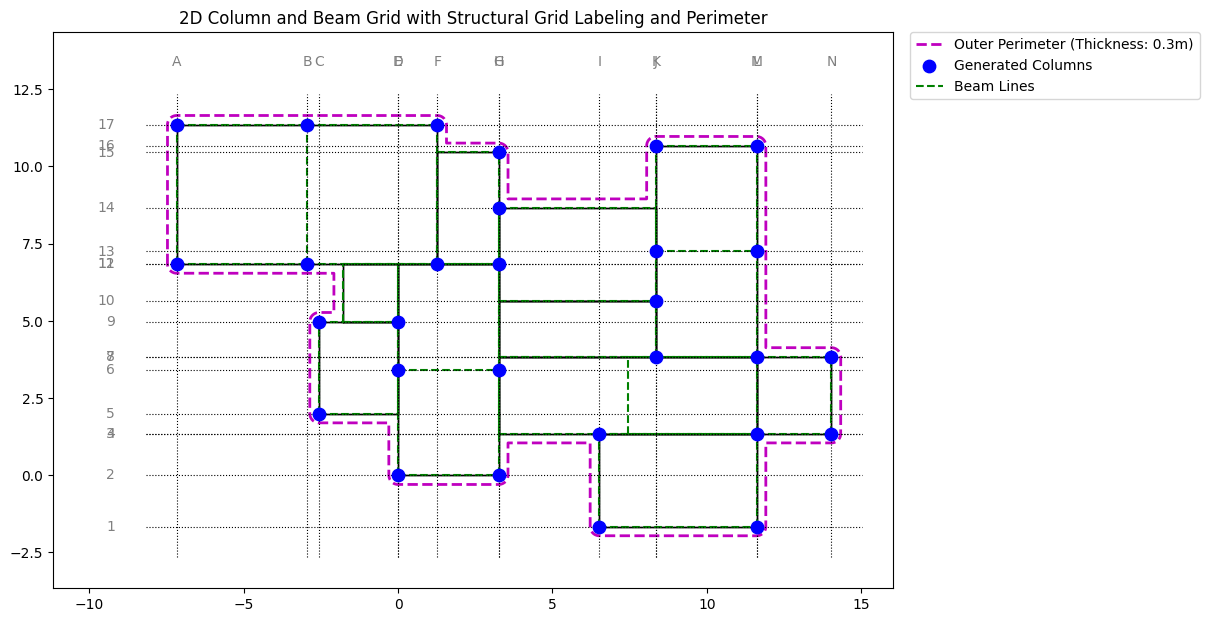

--- Generating data and Exporting CSVs & JSONs ---
Ensuring directory exists: c:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data
✅ nodes.csv written to ..\eleftheriaexperiment\structural_data\nodes.csv
✅ nodes.json written to ..\eleftheriaexperiment\structural_data\nodes.json
✅ columns.csv written to ..\eleftheriaexperiment\structural_data\columns.csv
✅ columns.json written to ..\eleftheriaexperiment\structural_data\columns.json
✅ beams.csv written to ..\eleftheriaexperiment\structural_data\beams.csv
✅ beams.json written to ..\eleftheriaexperiment\structural_data\beams.json


In [11]:
#MASHALLA FOR FORCED COLUMNS

import rhino3dm
import os
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import csv
import pandas as pd
from collections import OrderedDict
import json

# File path
rhino_path = r"..\Reference Files\coconuts.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)

# Extract geometries and their bounding boxes
building_floor_footprints = []
all_mesh_bboxes = []
roof_meshes_info = []
max_z = 0.0

Z_FLATNESS_TOLERANCE = 0.1

for obj in model.Objects:
    geom = obj.Geometry
    if geom.ObjectType == rhino3dm.ObjectType.Mesh:
        bbox = geom.GetBoundingBox()
        
        bbox_x_dim = bbox.Max.X - bbox.Min.X
        bbox_y_dim = bbox.Max.Y - bbox.Min.Y
        bbox_z_dim = bbox.Max.Z - bbox.Min.Z

        if bbox_z_dim < Z_FLATNESS_TOLERANCE and bbox_x_dim > 0.1 and bbox_y_dim > 0.1:
            base_pts = [
                [bbox.Min.X, bbox.Min.Y],
                [bbox.Max.X, bbox.Min.Y],
                [bbox.Max.X, bbox.Max.Y],
                [bbox.Min.X, bbox.Max.Y],
                [bbox.Min.X, bbox.Min.Y]
            ]
            poly = Polygon(base_pts)
            if poly.area > 1e-3:
                building_floor_footprints.append(poly)
                roof_meshes_info.append((obj.Attributes.Id, bbox, poly))

        all_mesh_bboxes.append(bbox)
        
        max_z = max(max_z, bbox.Max.Z)

if not building_floor_footprints:
    raise RuntimeError("No meaningful building floor footprints (meshes flat in Z with area) found in the model.")

print(f"Detected {len(building_floor_footprints)} building floor footprints. Max Z height: {max_z:.2f}m")
print(f"Total meshes contributing to height calculation: {len(all_mesh_bboxes)}")
print(f"Detected {len(roof_meshes_info)} potential roof meshes for comparison.")


# Find and print roofs that are peaks (taller than all directly touching roofs)
print("\n--- Analyzing Roof Heights ---")

INTERSECTION_BUFFER_ROOF = 0.1

dominant_roofs_identified = []

for i, (roof1_id, roof1_bbox, roof1_poly_2d) in enumerate(roof_meshes_info):
    roof1_max_z = roof1_bbox.Max.Z
    is_dominant_roof = True
    touching_lower_neighbors = []
    touching_equal_or_higher_neighbors = []

    for j, (roof2_id, roof2_bbox, roof2_poly_2d) in enumerate(roof_meshes_info):
        if i == j:
            continue

        roof2_max_z = roof2_bbox.Max.Z

        intersection_geometry = roof1_poly_2d.buffer(INTERSECTION_BUFFER_ROOF).intersection(roof2_poly_2d.buffer(INTERSECTION_BUFFER_ROOF))
        
        is_touching = not intersection_geometry.is_empty and \
                      intersection_geometry.geom_type in ['LineString', 'MultiLineString', 'Polygon', 'MultiPolygon']
        
        if is_touching:
            if roof1_max_z <= roof2_max_z + 1e-6:
                is_dominant_roof = False
                touching_equal_or_higher_neighbors.append({"Id": str(roof2_id), "Height": round(roof2_max_z, 3)})
            else:
                touching_lower_neighbors.append({"Id": str(roof2_id), "Height": round(roof2_max_z, 3)})
        
    if is_dominant_roof and (touching_lower_neighbors or touching_equal_or_higher_neighbors):
        dominant_roofs_identified.append({
            "RhinoObjectId": str(roof1_id),
            "Height": round(roof1_max_z, 3),
            "Location_Min_X": round(roof1_bbox.Min.X, 3),
            "Location_Min_Y": round(roof1_bbox.Min.Y, 3),
            "Polygon": roof1_poly_2d,
            "TouchingLowerNeighbors": touching_lower_neighbors,
            "TouchingEqualOrHigherNeighbors": touching_equal_or_higher_neighbors
        })

if dominant_roofs_identified:
    print("\nRoofs identified as strictly taller than all their directly touching neighbors:")
    for roof_info in dominant_roofs_identified:
        if not roof_info['TouchingEqualOrHigherNeighbors']:
            print(f"  Roof ID: {roof_info['RhinoObjectId']} (Height: {roof_info['Height']}m)")
            print(f"    Location (Min XY): ({roof_info['Location_Min_X']}, {roof_info['Location_Min_Y']})")
            if roof_info['TouchingLowerNeighbors']:
                neighbor_details = ", ".join([f"ID: {n['Id']} (H: {n['Height']}m)" for n in roof_info['TouchingLowerNeighbors']])
                print(f"    Touching Lower Neighbors: {neighbor_details}")
            else:
                print(f"    No directly touching lower neighbors found (might be isolated or higher than implied).")
else:
    print("\nNo roofs found that are strictly taller than all their directly touching neighbors.")


# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

combined_building_polygon = MultiPolygon(building_floor_footprints)

try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1)
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

detected_rooms = sorted([(poly, poly.area) for poly in building_floor_footprints], key=lambda x: -x[1])
if not detected_rooms:
    raise RuntimeError("No valid rooms detected after filtering by area. Check your Rhino model geometry.")


# Structural logic
MaxS = 6.0
MinS = 3.0

columns_2d_points = [] # Store raw (x,y) points for columns
beams_2d_lines = []    # Store raw ((x1,y1),(x2,y2)) for beams for 2D plot

added_column_xy = set()

# Force columns at the corners of dominant roof footprints
print("\n--- Forcing columns at dominant roof corners ---")
for roof_info in dominant_roofs_identified:
    if not roof_info['TouchingEqualOrHigherNeighbors']:
        poly_2d = roof_info['Polygon']
        minx, miny, maxx, maxy = poly_2d.bounds
        corners_to_force = [
            (minx, miny),
            (maxx, miny),
            (maxx, maxy),
            (minx, maxy)
        ]
        for cx, cy in corners_to_force:
            rounded_cx = round(cx, 5)
            rounded_cy = round(cy, 5)
            if (rounded_cx, rounded_cy) not in added_column_xy:
                columns_2d_points.append((rounded_cx, rounded_cy))
                added_column_xy.add((rounded_cx, rounded_cy))
                print(f"  Forced column at dominant roof corner: ({rounded_cx}, {rounded_cy})")


for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    
    divisions_x = max(1, int(np.ceil(width / MaxS)))
    divisions_y = max(1, int(np.ceil(height / MaxS)))
    
    x_points_grid = np.linspace(minx, maxx, divisions_x + 1)
    y_points_grid = np.linspace(miny, maxy, divisions_y + 1)
    
    # Add interior grid columns
    for x in x_points_grid:
        for y in y_points_grid:
            col_pt = Point(x, y)
            rounded_x = round(x, 5)
            rounded_y = round(y, 5)
            
            if room_poly.contains(col_pt) or room_poly.buffer(1e-6).contains(col_pt):
                if (rounded_x, rounded_y) not in added_column_xy:
                    if all(np.linalg.norm(np.array((rounded_x, rounded_y)) - np.array(exist_col_xy)) >= MinS for exist_col_xy in added_column_xy):
                        columns_2d_points.append((rounded_x, rounded_y))
                        added_column_xy.add((rounded_x, rounded_y))

    # Add columns at corners of the room polygon
    for corner_x, corner_y in room_poly.exterior.coords:
        corner_pt = (corner_x, corner_y)
        rounded_corner_x = round(corner_x, 5)
        rounded_corner_y = round(corner_y, 5)
        
        if (rounded_corner_x, rounded_corner_y) not in added_column_xy:
            if all(np.linalg.norm(np.array(corner_pt) - np.array(exist_col_xy)) >= MinS * 0.5 for exist_col_xy in added_column_xy):
                columns_2d_points.append(corner_pt)
                added_column_xy.add(corner_pt)

    # NEW BEAM GENERATION LOGIC:
    # Generate beams between adjacent grid points *within* the room polygon
    
    # Horizontal beams
    for y_fixed in y_points_grid:
        points_on_line = []
        for x_coord in x_points_grid:
            p = Point(x_coord, y_fixed)
            if room_poly.buffer(1e-6).contains(p):
                points_on_line.append((x_coord, y_fixed))
        
        # Connect adjacent points on this horizontal line
        if len(points_on_line) > 1:
            for i in range(len(points_on_line) - 1):
                beams_2d_lines.append((points_on_line[i], points_on_line[i+1]))

    # Vertical beams
    for x_fixed in x_points_grid:
        points_on_line = []
        for y_coord in y_points_grid:
            p = Point(x_fixed, y_coord)
            if room_poly.buffer(1e-6).contains(p):
                points_on_line.append((x_fixed, y_coord))
        
        # Connect adjacent points on this vertical line
        if len(points_on_line) > 1:
            for i in range(len(points_on_line) - 1):
                beams_2d_lines.append((points_on_line[i], points_on_line[i+1]))

# Remove duplicate 2D beam lines
unique_beams_2d = set()
for p1, p2 in beams_2d_lines:
    # Ensure consistent order for tuple comparison
    ordered_segment = tuple(sorted((tuple(np.round(p1,5)), tuple(np.round(p2,5)))))
    unique_beams_2d.add(ordered_segment)
beams_2d_lines = [ (np.array(p1), np.array(p2)) for p1,p2 in unique_beams_2d]


# Combine all base columns
all_base_columns = list(added_column_xy)

# --- COLUMN GRID NUMBERING LOGIC ---
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

grid_extent_buffer = 1.0
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) - 3.0 if perimeter_line_coords else col_min_x_extent - 3.0
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) + 1.0 if perimeter_line_coords else col_max_x_extent + 1.0
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) - 1.0 if perimeter_line_coords else col_min_y_extent - 1.0
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) + 2.0 if perimeter_line_coords else col_max_y_extent + 2.0


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10))

for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

gx, gy = zip(*columns_2d_points)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

if beams_2d_lines:
    first_beam_plotted = False
    for p1, p2 in beams_2d_lines:
        if not first_beam_plotted:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')
            first_beam_plotted = True
        else:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linestyle='--', linewidth=1.5)

for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8)
    ax.text(x_coord, col_max_y_extent + 0.8, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray')

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8)
    ax.text(col_min_x_extent - 1.0, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray')

ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()


# --- Utility function for wall height ---
def get_wall_height(x, y, mesh_bboxes, global_max_z):
    pt = Point(x, y)
    relevant_bboxes = []
    for bbox in mesh_bboxes:
        bbox_poly = Polygon([
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Min.Y]
        ])
        if bbox_poly.buffer(1e-4).contains(pt):
            relevant_bboxes.append(bbox)

    if not relevant_bboxes:
        return global_max_z 

    max_relevant_z = 0.0
    for bbox in relevant_bboxes:
        max_relevant_z = max(max_relevant_z, bbox.Max.Z)
        
    return max_relevant_z if max_relevant_z > 0 else global_max_z


# --- DATA GENERATION AND CSV/JSON EXPORT ---
print("--- Generating data and Exporting CSVs & JSONs ---")

EXPORT_SAVE_PATH = r"..\eleftheriaexperiment\structural_data"

os.makedirs(EXPORT_SAVE_PATH, exist_ok=True)
print(f"Ensuring directory exists: {os.path.abspath(EXPORT_SAVE_PATH)}")

node_coords = []
node_dict = OrderedDict()

def add_node(pt):
    key = tuple(np.round(pt, 5))
    if key not in node_dict:
        node_id = f"N{len(node_dict)}"
        node_dict[key] = node_id
        node_coords.append([node_id] + list(key))
    return node_dict[key]

column_lines = []
for x, y in all_base_columns:
    current_column_max_z = get_wall_height(x, y, all_mesh_bboxes, max_z)
    
    for i in range(num_floors + 1):
        z_level = (i / num_floors) * current_column_max_z if num_floors > 0 else current_column_max_z
        z_level = max(0, z_level) 

        if i == 0:
            id_btm_ground = add_node((x, y, 0))
            if num_floors == 0:
                pass 
            elif num_floors > 0:
                id_first_floor = add_node((x, y, z_level))
                if z_level > 1e-6:
                    column_lines.append((id_btm_ground, id_first_floor))
        elif i > 0:
            prev_z_level = ((i-1) / num_floors) * current_column_max_z if num_floors > 0 else 0
            
            actual_z_level = min(z_level, current_column_max_z)
            actual_prev_z_level = min(prev_z_level, current_column_max_z)

            if actual_z_level > actual_prev_z_level + 1e-6 and actual_z_level <= current_column_max_z + 1e-6: 
                id_prev_node = add_node((x, y, actual_prev_z_level))
                id_current_node = add_node((x, y, actual_z_level))
                column_lines.append((id_prev_node, id_current_node))


beam_lines = []
unique_beam_tuples_3d = set() # Use a new set for 3D beam uniqueness

# Generate 3D beams based on the 2D beam lines and floor heights
for (x1, y1), (x2, y2) in beams_2d_lines:
    # For a beam, its height should be relative to the floor it is on.
    # We'll use the *average* max_z of its two endpoints' column paths, or simply the max_z
    # of the area it traverses, which `get_wall_height` does for its midpoint.
    
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    # This height should represent the highest point for any column *at that X,Y location*.
    # So, the beam should extend to the highest floor in the "local building block" it belongs to.
    beam_local_max_z = get_wall_height(mid_x, mid_y, all_mesh_bboxes, max_z)
    
    for i in range(1, num_floors + 1): # Beams are usually at floor levels (from 1st floor up to roof)
        floor_z_level = (i / num_floors) * beam_local_max_z if num_floors > 0 else 0
        
        # If the calculated floor_z_level for this beam is very close to zero, and we have multiple floors,
        # it likely means this beam is in a section that does not rise above ground, so skip it for upper floors.
        if num_floors > 0 and floor_z_level < 1e-6:
            continue
        
        # Round the z_level to ensure consistent node snapping
        floor_z_level_rounded = round(floor_z_level, 5)

        # Get/add nodes for the beam endpoints at the current floor's Z
        id1 = add_node((x1, y1, floor_z_level_rounded))
        id2 = add_node((x2, y2, floor_z_level_rounded))
        
        # Add to unique set to prevent duplicate beams in the output
        ordered_nodes = tuple(sorted((id1, id2)))
        if ordered_nodes not in unique_beam_tuples_3d:
            unique_beam_tuples_3d.add(ordered_nodes)
            beam_lines.append((id1, id2))


# --- Export nodes.csv ---
nodes_csv_path = os.path.join(EXPORT_SAVE_PATH, "nodes.csv")
df_nodes = pd.DataFrame(node_coords, columns=["ID", "X", "Y", "Z"])
df_nodes.to_csv(nodes_csv_path, index=False)
print(f"✅ nodes.csv written to {nodes_csv_path}")

# --- Export nodes.json ---
nodes_json_path = os.path.join(EXPORT_SAVE_PATH, "nodes.json")
nodes_json_data = []
for node in node_coords:
    nodes_json_data.append({
        "ID": node[0],
        "X": node[1],
        "Y": node[2],
        "Z": node[3]
    })
with open(nodes_json_path, 'w') as f:
    json.dump(nodes_json_data, f, indent=4)
print(f"✅ nodes.json written to {nodes_json_path}")

# --- Export columns.csv ---
col_data = []
for i, (i_node_id, j_node_id) in enumerate(column_lines):
    p1_coords = df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]
    p2_coords = df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2_coords - p1_coords)
    col_data.append([f"C{i}", i_node_id, j_node_id, round(length, 3)])

columns_csv_path = os.path.join(EXPORT_SAVE_PATH, "columns.csv")
df_columns = pd.DataFrame(col_data, columns=["ID", "i_node", "j_node", "length"])
df_columns.to_csv(columns_csv_path, index=False)
print(f"✅ columns.csv written to {columns_csv_path}")

# --- Export columns.json ---
columns_json_path = os.path.join(EXPORT_SAVE_PATH, "columns.json")
columns_json_data = []
for i, (i_node_id, j_node_id) in enumerate(column_lines):
    columns_json_data.append({
        "ID": f"C{i}",
        "i_node": i_node_id,
        "j_node": j_node_id,
        "length": round(np.linalg.norm(df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0] - \
                                         df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]), 3)
    })
with open(columns_json_path, 'w') as f:
    json.dump(columns_json_data, f, indent=4)
print(f"✅ columns.json written to {columns_json_path}")


# --- Export beams.csv ---
beam_data = []
for i, (i_node_id, j_node_id) in enumerate(beam_lines):
    p1_coords = df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]
    p2_coords = df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2_coords - p1_coords)
    beam_data.append([f"B{i}", i_node_id, j_node_id, round(length, 3)])

beams_csv_path = os.path.join(EXPORT_SAVE_PATH, "beams.csv")
df_beams = pd.DataFrame(beam_data, columns=["ID", "i_node", "j_node", "length"])
df_beams.to_csv(beams_csv_path, index=False)
print(f"✅ beams.csv written to {beams_csv_path}")

# --- Export beams.json ---
beams_json_path = os.path.join(EXPORT_SAVE_PATH, "beams.json")
beams_json_data = []
for i, (i_node_id, j_node_id) in enumerate(beam_lines):
    beams_json_data.append({
        "ID": f"B{i}",
        "i_node": i_node_id,
        "j_node": j_node_id,
        "length": round(np.linalg.norm(df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0] - \
                                         df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]), 3)
    })
with open(beams_json_path, 'w') as f:
    json.dump(beams_json_data, f, indent=4)
print(f"✅ beams.json written to {beams_json_path}")

In [10]:
#correct csv viewer

import pandas as pd
import plotly.graph_objects as go
import os
import numpy as np
import rhino3dm
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from collections import OrderedDict # Re-import for OrderedDict if not already global

# --- Re-load data and re-run identification logic to ensure all variables are defined ---
# This part is a copy of the previous cell's data loading and identification logic
# to ensure this cell can run independently if the previous one wasn't executed immediately before.

base_github_path = r"C:\Users\papad\Documents\GitHub\Octopusie"
CSV_SAVE_PATH = os.path.join(base_github_path, "eleftheriaexperiment", "structural_data")
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.3dm"

print(f"Re-attempting to load CSVs from: {os.path.abspath(CSV_SAVE_PATH)}")
print(f"Re-attempting to load Rhino model from: {os.path.abspath(rhino_path)}")

try:
    df_nodes_loaded = pd.read_csv(nodes_csv_path)
    df_columns_loaded = pd.read_csv(columns_csv_path)
    df_beams_loaded = pd.read_csv(beams_csv_path)
    print("✅ CSV files loaded successfully for update process.")
except FileNotFoundError:
    print("Error: Make sure 'nodes.csv', 'columns.csv', and 'beams.csv' are in the specified path.")
    print("Exiting as data is required for operations.")
    exit()

if not os.path.exists(rhino_path):
    print(f"Error: Rhino file not found at {rhino_path}. Cannot identify peak roofs for re-processing.")
    exit()

model = rhino3dm.File3dm.Read(rhino_path)

building_floor_footprints = []
all_mesh_bboxes = []
roof_meshes_info = []
max_z_overall_model = 0.0
Z_FLATNESS_TOLERANCE = 0.1

for obj in model.Objects:
    geom = obj.Geometry
    if geom.ObjectType == rhino3dm.ObjectType.Mesh:
        bbox = geom.GetBoundingBox()
        bbox_z_dim = bbox.Max.Z - bbox.Min.Z
        if bbox_z_dim < Z_FLATNESS_TOLERANCE and (bbox.Max.X - bbox.Min.X) > 0.1 and (bbox.Max.Y - bbox.Min.Y) > 0.1:
            base_pts = [[bbox.Min.X, bbox.Min.Y], [bbox.Max.X, bbox.Min.Y], [bbox.Max.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y], [bbox.Min.X, bbox.Min.Y]]
            poly = Polygon(base_pts)
            if poly.area > 1e-3:
                building_floor_footprints.append(poly)
                roof_meshes_info.append((obj.Attributes.Id, bbox, poly))
        all_mesh_bboxes.append(bbox)
        max_z_overall_model = max(max_z_overall_model, bbox.Max.Z)

def get_wall_height(x, y, mesh_bboxes, global_max_z):
    pt = Point(x, y)
    relevant_bboxes = []
    for bbox in mesh_bboxes:
        bbox_poly = Polygon([[bbox.Min.X, bbox.Min.Y], [bbox.Max.X, bbox.Min.Y], [bbox.Max.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y], [bbox.Min.X, bbox.Min.Y]])
        if bbox_poly.buffer(1e-4).contains(pt):
            relevant_bboxes.append(bbox)
    if not relevant_bboxes: return global_max_z
    max_relevant_z = 0.0
    for bbox in relevant_bboxes:
        max_relevant_z = max(max_relevant_z, bbox.Max.Z)
    return max_relevant_z if max_relevant_z > 0 else global_max_z

# Re-identify dominant roofs
INTERSECTION_BUFFER_ROOF = 0.1
dominant_roofs_identified = []
for i, (roof1_id, roof1_bbox, roof1_poly_2d) in enumerate(roof_meshes_info):
    roof1_max_z = roof1_bbox.Max.Z
    is_dominant_roof = True
    for j, (roof2_id, roof2_bbox, roof2_poly_2d) in enumerate(roof_meshes_info):
        if i == j: continue
        roof2_max_z = roof2_bbox.Max.Z
        intersection_geometry = roof1_poly_2d.buffer(INTERSECTION_BUFFER_ROOF).intersection(roof2_poly_2d.buffer(INTERSECTION_BUFFER_ROOF))
        is_touching = not intersection_geometry.is_empty and intersection_geometry.geom_type in ['LineString', 'MultiLineString', 'Polygon', 'MultiPolygon']
        if is_touching:
            if roof1_max_z <= roof2_max_z + 1e-6:
                is_dominant_roof = False
                break
    if is_dominant_roof and (len(roof_meshes_info) > 1 or len(dominant_roofs_identified) == 0):
        if not is_dominant_roof: continue
        dominant_roofs_identified.append({"RhinoObjectId": str(roof1_id), "Height": round(roof1_max_z, 3), "Polygon_2D": roof1_poly_2d})

# Re-identify peak roof beams
peak_roof_beam_ids = set()
Z_HEIGHT_TOLERANCE = 0.5
node_id_to_coords = df_nodes_loaded.set_index('ID')[['X', 'Y', 'Z']].T.to_dict('list')

for index, row in df_beams_loaded.iterrows():
    beam_id = row['ID']
    n1_id = row['i_node']
    n2_id = row['j_node']
    try:
        p1_coords = np.array(node_id_to_coords[n1_id])
        p2_coords = np.array(node_id_to_coords[n2_id])
    except KeyError:
        continue
    mid_x, mid_y = (p1_coords[0] + p2_coords[0]) / 2, (p1_coords[1] + p2_coords[1]) / 2
    avg_z = (p1_coords[2] + p2_coords[2]) / 2
    beam_midpoint_2d = Point(mid_x, mid_y)
    for roof_info in dominant_roofs_identified:
        roof_polygon_2d = roof_info['Polygon_2D']
        roof_peak_height = roof_info['Height']
        if roof_polygon_2d.buffer(1e-3).contains(beam_midpoint_2d) and abs(avg_z - roof_peak_height) < Z_HEIGHT_TOLERANCE:
            peak_roof_beam_ids.add(beam_id)
            break

# Re-identify low-connectivity linear beams on peak roofs
beam_adj_list = {node_id: [] for node_id in df_nodes_loaded['ID']}
for index, row in df_beams_loaded.iterrows():
    beam_adj_list[row['i_node']].append(row['ID'])
    beam_adj_list[row['j_node']].append(row['ID'])

def angle_between_vectors(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    unit_vector_1 = v1 / (np.linalg.norm(v1) + 1e-9)
    unit_vector_2 = v2 / (np.linalg.norm(v2) + 1e-9)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.degrees(angle_rad)

COLLINEARITY_TOLERANCE_DEG = 10 
highlighted_peak_roof_beams = set()

if not df_beams_loaded.empty:
    for index, row in df_beams_loaded.iterrows():
        beam_id = row['ID']
        if beam_id not in peak_roof_beam_ids:
            continue

        n1_id, n2_id = row['i_node'], row['j_node']
        is_low_connectivity_linear = False

        if len(beam_adj_list[n1_id]) == 2:
            other_beam_ids_at_n1 = [b_id for b_id in beam_adj_list[n1_id] if b_id != beam_id]
            if other_beam_ids_at_n1:
                other_beam_id_at_n1 = other_beam_ids_at_n1[0]
                current_beam_other_node = n2_id
                other_beam_row = df_beams_loaded[df_beams_loaded['ID'] == other_beam_id_at_n1].iloc[0]
                other_beam_other_node = other_beam_row['i_node'] if other_beam_row['j_node'] == n1_id else other_beam_row['j_node']
                coords_n1 = np.array(node_id_to_coords.get(n1_id, [0,0,0]))
                coords_current_other = np.array(node_id_to_coords.get(current_beam_other_node, [0,0,0]))
                coords_other_beam_other = np.array(node_id_to_coords.get(other_beam_other_node, [0,0,0]))
                vector_current_beam = coords_current_other - coords_n1
                vector_other_beam = coords_other_beam_other - coords_n1
                angle = angle_between_vectors(vector_current_beam, vector_other_beam)
                if abs(angle) < COLLINEARITY_TOLERANCE_DEG or abs(angle - 180) < COLLINEARITY_TOLERANCE_DEG:
                    is_low_connectivity_linear = True

        if not is_low_connectivity_linear and len(beam_adj_list[n2_id]) == 2:
            other_beam_ids_at_n2 = [b_id for b_id in beam_adj_list[n2_id] if b_id != beam_id]
            if other_beam_ids_at_n2:
                other_beam_id_at_n2 = other_beam_ids_at_n2[0]
                current_beam_other_node = n1_id
                other_beam_row = df_beams_loaded[df_beams_loaded['ID'] == other_beam_id_at_n2].iloc[0]
                other_beam_other_node = other_beam_row['i_node'] if other_beam_row['j_node'] == n2_id else other_beam_row['j_node']
                coords_n2 = np.array(node_id_to_coords.get(n2_id, [0,0,0]))
                coords_current_other = np.array(node_id_to_coords.get(current_beam_other_node, [0,0,0]))
                coords_other_beam_other = np.array(node_id_to_coords.get(other_beam_other_node, [0,0,0]))
                vector_current_beam = coords_current_other - coords_n2
                vector_other_beam = coords_other_beam_other - coords_n2
                angle = angle_between_vectors(vector_current_beam, vector_other_beam)
                if abs(angle) < COLLINEARITY_TOLERANCE_DEG or abs(angle - 180) < COLLINEARITY_TOLERANCE_DEG:
                    is_low_connectivity_linear = True

        if not is_low_connectivity_linear:
            if len(beam_adj_list[n1_id]) == 1 or len(beam_adj_list[n2_id]) == 1:
                is_low_connectivity_linear = True
        
        if is_low_connectivity_linear:
            highlighted_peak_roof_beams.add(beam_id)

print(f"\nIdentified {len(highlighted_peak_roof_beams)} beam segments that are low-connectivity linear ends AND on peak roofs for deletion.")
print("IDs of beams to be deleted:")
for beam_id in sorted(list(highlighted_peak_roof_beams)):
    print(f"- {beam_id}")

# --- END Re-run identification logic ---


# --- DELETE BEAMS AND UPDATE DATA ---
print("\n--- Deleting identified beams and updating structural data ---")

# Filter df_beams_loaded to remove the identified beams
df_beams_updated = df_beams_loaded[~df_beams_loaded['ID'].isin(highlighted_peak_roof_beams)].copy()

# Now, re-prune nodes based on the remaining beams and all columns
connected_nodes_after_deletion = set()

# Add nodes from columns
if not df_columns_loaded.empty:
    connected_nodes_after_deletion.update(df_columns_loaded["i_node"].tolist())
    connected_nodes_after_deletion.update(df_columns_loaded["j_node"].tolist())

# Add nodes from the updated beams
if not df_beams_updated.empty:
    connected_nodes_after_deletion.update(df_beams_updated["i_node"].tolist())
    connected_nodes_after_deletion.update(df_beams_updated["j_node"].tolist())

print(f"Initial nodes count: {len(df_nodes_loaded)}")
print(f"Nodes connected after beam deletion: {len(connected_nodes_after_deletion)}")

# Filter nodes and re-map IDs
df_nodes_updated = df_nodes_loaded[df_nodes_loaded['ID'].isin(connected_nodes_after_deletion)].copy()
new_node_id_mapping = {old_id: f"N{i}" for i, old_id in enumerate(df_nodes_updated['ID'])}
df_nodes_updated['ID'] = df_nodes_updated['ID'].map(new_node_id_mapping)

# Rebuild node_lookup_loaded and node_id_to_coords with updated nodes
node_lookup_loaded = df_nodes_updated.set_index('ID')
node_id_to_coords = df_nodes_updated.set_index('ID')[['X', 'Y', 'Z']].T.to_dict('list')

# Re-map node IDs in columns DataFrame
df_columns_updated = df_columns_loaded.copy()
df_columns_updated['i_node'] = df_columns_updated['i_node'].map(new_node_id_mapping)
df_columns_updated['j_node'] = df_columns_updated['j_node'].map(new_node_id_mapping)
# Filter out columns whose nodes might have been deleted (map result will be NaN for deleted nodes)
df_columns_updated.dropna(subset=['i_node', 'j_node'], inplace=True)
df_columns_updated['ID'] = [f"C{i}" for i in range(len(df_columns_updated))] # Re-index column IDs


# Re-map node IDs in the updated beams DataFrame
df_beams_updated['i_node'] = df_beams_updated['i_node'].map(new_node_id_mapping)
df_beams_updated['j_node'] = df_beams_updated['j_node'].map(new_node_id_mapping)
# Filter out beams whose nodes might have been deleted
df_beams_updated.dropna(subset=['i_node', 'j_node'], inplace=True)
df_beams_updated['ID'] = [f"B{i}" for i in range(len(df_beams_updated))] # Re-index beam IDs


print(f"Final nodes count: {len(df_nodes_updated)}")
print(f"Final columns count: {len(df_columns_updated)}")
print(f"Final beams count: {len(df_beams_updated)}")


# --- EXPORT UPDATED CSVS AND JSONS ---
print("\n--- Exporting updated CSVs & JSONs ---")

nodes_csv_path_updated = os.path.join(CSV_SAVE_PATH, "nodes.csv")
df_nodes_updated.to_csv(nodes_csv_path_updated, index=False)
print(f"✅ nodes.csv (updated) written to {nodes_csv_path_updated}")

nodes_json_path_updated = os.path.join(CSV_SAVE_PATH, "nodes.json")
nodes_json_data = df_nodes_updated.to_dict(orient='records')
with open(nodes_json_path_updated, 'w') as f:
    json.dump(nodes_json_data, f, indent=4)
print(f"✅ nodes.json (updated) written to {nodes_json_path_updated}")

columns_csv_path_updated = os.path.join(CSV_SAVE_PATH, "columns.csv")
df_columns_updated.to_csv(columns_csv_path_updated, index=False)
print(f"✅ columns.csv (updated) written to {columns_csv_path_updated}")

columns_json_path_updated = os.path.join(CSV_SAVE_PATH, "columns.json")
columns_json_data = df_columns_updated.to_dict(orient='records')
with open(columns_json_path_updated, 'w') as f:
    json.dump(columns_json_data, f, indent=4)
print(f"✅ columns.json (updated) written to {columns_json_path_updated}")

beams_csv_path_updated = os.path.join(CSV_SAVE_PATH, "beams.csv")
df_beams_updated.to_csv(beams_csv_path_updated, index=False)
print(f"✅ beams.csv (updated) written to {beams_csv_path_updated}")

beams_json_path_updated = os.path.join(CSV_SAVE_PATH, "beams.json")
beams_json_data = df_beams_updated.to_dict(orient='records')
with open(beams_json_path_updated, 'w') as f:
    json.dump(beams_json_data, f, indent=4)
print(f"✅ beams.json (updated) written to {beams_json_path_updated}")


# --- RE-VISUALIZE THE UPDATED STRUCTURE ---
print("\n--- Re-visualizing the updated structural model ---")

# Prepare data for plotting lines (columns and beams from updated DFs)
column_plotly_lines_x, column_plotly_lines_y, column_plotly_lines_z = [], [], []
beam_plotly_lines_x, beam_plotly_lines_y, beam_plotly_lines_z = [], [], []

# Add Columns to line data
for index, row in df_columns_updated.iterrows():
    try:
        p1 = node_lookup_loaded.loc[row['i_node'], ['X', 'Y', 'Z']]
        p2 = node_lookup_loaded.loc[row['j_node'], ['X', 'Y', 'Z']]
        column_plotly_lines_x.extend([p1['X'], p2['X'], None])
        column_plotly_lines_y.extend([p1['Y'], p2['Y'], None])
        column_plotly_lines_z.extend([p1['Z'], p2['Z'], None])
    except KeyError as e:
        print(f"Warning: Node ID not found in lookup for updated column {row['ID']}: {e}. Skipping.")

# Add Beams to line data
for index, row in df_beams_updated.iterrows():
    try:
        p1 = node_lookup_loaded.loc[row['i_node'], ['X', 'Y', 'Z']]
        p2 = node_lookup_loaded.loc[row['j_node'], ['X', 'Y', 'Z']]
        beam_plotly_lines_x.extend([p1['X'], p2['X'], None])
        beam_plotly_lines_y.extend([p1['Y'], p2['Y'], None])
        beam_plotly_lines_z.extend([p1['Z'], p2['Z'], None])
    except KeyError as e:
        print(f"Warning: Node ID not found in lookup for updated beam {row['ID']}: {e}. Skipping.")


# Create Plotly traces for nodes, columns, and beams using the UPDATED DataFrames
trace_nodes = go.Scatter3d(
    x=df_nodes_updated['X'],
    y=df_nodes_updated['Y'],
    z=df_nodes_updated['Z'],
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Nodes',
    text=df_nodes_updated['ID'],
    hoverinfo='text'
)

trace_columns = go.Scatter3d(
    x=column_plotly_lines_x,
    y=column_plotly_lines_y,
    z=column_plotly_lines_z,
    mode='lines',
    line=dict(color='blue', width=5),
    name='Columns'
)

trace_beams = go.Scatter3d(
    x=beam_plotly_lines_x,
    y=beam_plotly_lines_y,
    z=beam_plotly_lines_z,
    mode='lines',
    line=dict(color='green', width=3),
    name='Beams'
)

# Create the Plotly figure
fig = go.Figure(data=[trace_nodes, trace_columns, trace_beams])

# Set layout properties
fig.update_layout(
    title='3D Structural Visualization: Low-Connectivity Linear Beams on Peak Roofs DELETED',
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Display the plot
fig.show()


Re-attempting to load CSVs from: C:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data
Re-attempting to load Rhino model from: C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.3dm
✅ CSV files loaded successfully for update process.

Identified 0 beam segments that are low-connectivity linear ends AND on peak roofs for deletion.
IDs of beams to be deleted:

--- Deleting identified beams and updating structural data ---
Initial nodes count: 117
Nodes connected after beam deletion: 117
Final nodes count: 117
Final columns count: 58
Final beams count: 108

--- Exporting updated CSVs & JSONs ---
✅ nodes.csv (updated) written to C:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data\nodes.csv
✅ nodes.json (updated) written to C:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data\nodes.json
✅ columns.csv (updated) written to C:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data

Loading GLB file from: ..\Reference Files\coconuts.glb
Processing mesh: Mesh_0
Processing mesh: Mesh_1
Processing mesh: Mesh_2
Processing mesh: Mesh_3
Processing mesh: Mesh_4
Processing mesh: Mesh_5
Processing mesh: Mesh_6
Processing mesh: Mesh_7
Processing mesh: Mesh_8
Processing mesh: Mesh_9
Processing mesh: Mesh_10
Saving 3dm file to: ..\Reference Files\coconuts.3dm
Conversion complete!

Conversion successful! The 3DM file is saved at: ..\Reference Files\coconuts.3dm
Detected 22 building floor footprints. Max Z height: 6.00m
Total meshes contributing to height calculation: 66
Detected 22 potential roof meshes for comparison.

--- Analyzing Roof Heights ---

No roofs found that are strictly taller than all their directly touching neighbors.

--- Forcing columns at dominant roof corners ---


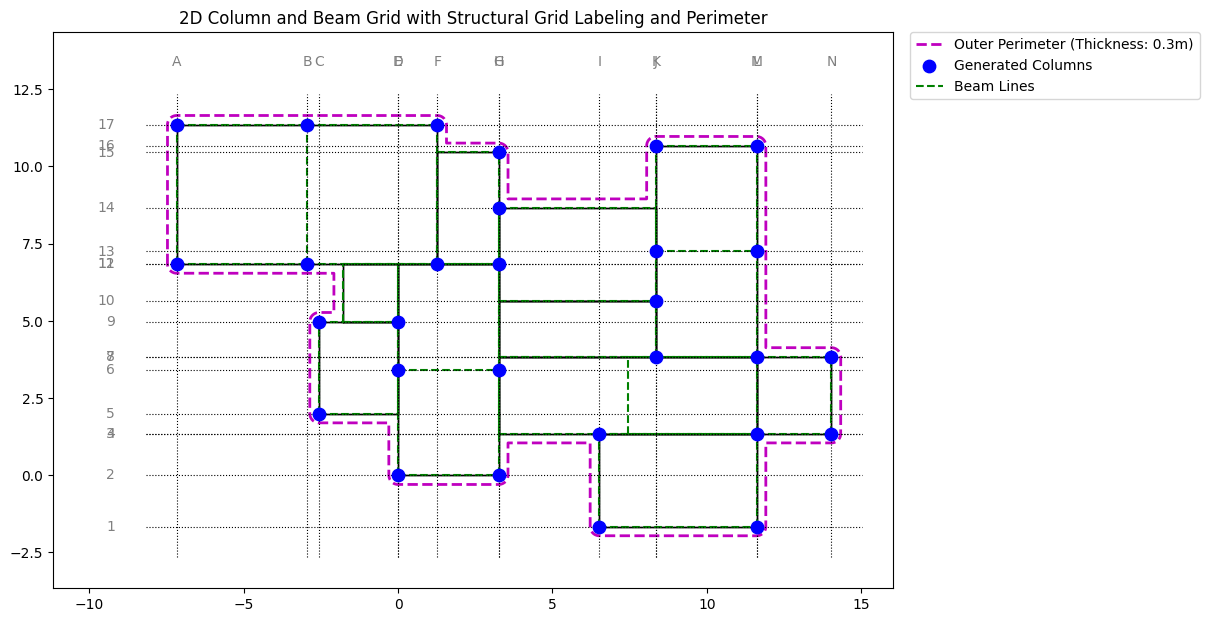

--- Generating data and Exporting CSVs & JSONs ---
Ensuring directory exists: c:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data
✅ nodes.csv written to ..\eleftheriaexperiment\structural_data\nodes.csv
✅ nodes.json written to ..\eleftheriaexperiment\structural_data\nodes.json
✅ columns.csv written to ..\eleftheriaexperiment\structural_data\columns.csv
✅ columns.json written to ..\eleftheriaexperiment\structural_data\columns.json
✅ beams.csv written to ..\eleftheriaexperiment\structural_data\beams.csv
✅ beams.json written to ..\eleftheriaexperiment\structural_data\beams.json
Re-attempting to load CSVs from: C:\Users\papad\Documents\GitHub\Octopusie\eleftheriaexperiment\structural_data
Re-attempting to load Rhino model from: c:\Users\papad\Documents\GitHub\Octopusie\Reference Files\coconuts.3dm
✅ CSV files loaded successfully for update process.

Identified 0 beam segments that are low-connectivity linear ends AND on peak roofs for deletion.
IDs of beams to be


COLUMN SLENDERNESS CHECK (L/r):
   Column C0: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C1: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C2: L=87.56 in, r=1.28 in → L/r=68.6 (PASS)
   Column C3: L=87.56 in, r=1.28 in → L/r=68.6 (PASS)
   Column C4: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C5: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C6: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C7: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C8: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C9: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C10: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C11: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C12: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C13: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C14: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C15: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C16: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C17: L=118.11 in,

In [14]:
# %pip install -q rhino3dm shapely trimesh matplotlib pyvista pandas
# %pip install PyniteFEA[all]
# %pip install Pynite
# %pip install trimesh
# pip install pygltflib

#--------------------------------------------------------------
#GLB TO 3DM CONVERTER
#--------------------------------------------------------------

import pygltflib
import rhino3dm
import os
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import csv
import pandas as pd
from collections import OrderedDict
import json

def convert_glb_to_3dm(glb_path, output_3dm_path):
    """
    Loads a GLB file, extracts its mesh data, and saves it as a 3dm file.
    Only mesh geometry will be converted. Materials, animations, etc., are not translated.
    """
    if not os.path.exists(glb_path):
        raise FileNotFoundError(f"GLB file not found: {glb_path}")

    print(f"Loading GLB file from: {glb_path}")
    gltf = pygltflib.GLTF2().load(glb_path)

    model_3dm = rhino3dm.File3dm()

    # Iterate through GLTF meshes and add them to the 3dm model
    for mesh_idx, gltf_mesh in enumerate(gltf.meshes):
        print(f"Processing mesh: {gltf_mesh.name if gltf_mesh.name else f'Mesh_{mesh_idx}'}")
        
        for primitive in gltf_mesh.primitives:
            # Get vertex positions
            accessor_pos = gltf.accessors[primitive.attributes.POSITION]
            buffer_view_pos = gltf.bufferViews[accessor_pos.bufferView]
            buffer_pos = gltf.buffers[buffer_view_pos.buffer]
            
            # Extract vertices
            # Pygltflib returns data as bytes, convert to numpy array
            vertices_bytes = gltf.get_data_from_buffer_uri(buffer_pos.uri)[
                buffer_view_pos.byteOffset : buffer_view_pos.byteOffset + buffer_view_pos.byteLength
            ]
            # Assuming float32 for positions (common in glTF)
            vertices = np.frombuffer(vertices_bytes, dtype=np.float32).reshape(-1, 3)

            rhino_mesh = rhino3dm.Mesh()
            for v in vertices:
                rhino_mesh.Vertices.Add(v[0], v[1], v[2])

            # Get indices (faces)
            if primitive.indices is not None:
                accessor_indices = gltf.accessors[primitive.indices]
                buffer_view_indices = gltf.bufferViews[accessor_indices.bufferView]
                buffer_indices = gltf.buffers[buffer_view_indices.buffer]

                indices_bytes = gltf.get_data_from_buffer_uri(buffer_indices.uri)[
                    buffer_view_indices.byteOffset : buffer_view_indices.byteOffset + buffer_view_indices.byteLength
                ]
                
                # Determine dtype for indices (UINT8, UINT16, UINT32)
                if accessor_indices.componentType == pygltflib.UNSIGNED_BYTE:
                    indices_dtype = np.uint8
                elif accessor_indices.componentType == pygltflib.UNSIGNED_SHORT:
                    indices_dtype = np.uint16
                elif accessor_indices.componentType == pygltflib.UNSIGNED_INT:
                    indices_dtype = np.uint32
                else:
                    print(f"Warning: Unsupported index component type: {accessor_indices.componentType}. Skipping faces for this primitive.")
                    continue

                indices = np.frombuffer(indices_bytes, dtype=indices_dtype)

                # glTF uses flat arrays for indices, assuming triangles (mode 4)
                if primitive.mode == pygltflib.TRIANGLES: # Mode 4 for triangles
                    for i in range(0, len(indices), 3):
                        rhino_mesh.Faces.AddFace(int(indices[i]), int(indices[i+1]), int(indices[i+2]))
                else:
                    print(f"Warning: Skipping primitive with unsupported mode: {primitive.mode}. Only triangles (mode 4) are fully supported for faces.")
                    continue
            else:
                print(f"Warning: Primitive has no indices. Assuming sequential triangles, but this might not be correct for complex GLBs.")
                # If no indices, assume sequential triangles (0,1,2, 3,4,5, etc.)
                # This is less common for actual models but might happen.
                for i in range(0, len(vertices) - 2, 3):
                    rhino_mesh.Faces.AddFace(i, i+1, i+2)

            # Optional: Calculate normals (good practice for rendering)
            rhino_mesh.Normals.ComputeNormals()
            rhino_mesh.Compact() # Optimize mesh

            model_3dm.Objects.AddMesh(rhino_mesh)
    
    print(f"Saving 3dm file to: {output_3dm_path}")
    model_3dm.Write(output_3dm_path, 0) # 0 means "use default options"
    print("Conversion complete!")

# --- Define paths ---
# The path to your GLB file
glb_file_path = r"..\Reference Files\coconuts.glb"

# Derive the output 3dm file path from the GLB file path
directory = os.path.dirname(glb_file_path)
file_name_without_ext = os.path.splitext(os.path.basename(glb_file_path))[0]
output_3dm_file_path = os.path.join(directory, f"{file_name_without_ext}.3dm")

# --- Run the conversion ---
try:
    convert_glb_to_3dm(glb_file_path, output_3dm_file_path)
    print(f"\nConversion successful! The 3DM file is saved at: {output_3dm_file_path}")

    # Now, you can run your original code using this new 3dm file
    # Example (assuming your original code is in the same script or imported):
    # original_rhino_path = output_3dm_file_path
    # model = rhino3dm.File3dm.Read(original_rhino_path)
    # # ... continue with the rest of your original script using 'model' ...

except FileNotFoundError as e:
    print(e)
    print("Please ensure the GLB file path is correct.")
except Exception as e:
    print(f"An error occurred during conversion: {e}")


#--------------------------------------------------------------
#MASHALLA FOR FORCED COLUMNS
#--------------------------------------------------------------


# File path
rhino_path = r"..\Reference Files\coconuts.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)

# Extract geometries and their bounding boxes
building_floor_footprints = []
all_mesh_bboxes = []
roof_meshes_info = []
max_z = 0.0

Z_FLATNESS_TOLERANCE = 0.1

for obj in model.Objects:
    geom = obj.Geometry
    if geom.ObjectType == rhino3dm.ObjectType.Mesh:
        bbox = geom.GetBoundingBox()
        
        bbox_x_dim = bbox.Max.X - bbox.Min.X
        bbox_y_dim = bbox.Max.Y - bbox.Min.Y
        bbox_z_dim = bbox.Max.Z - bbox.Min.Z

        if bbox_z_dim < Z_FLATNESS_TOLERANCE and bbox_x_dim > 0.1 and bbox_y_dim > 0.1:
            base_pts = [
                [bbox.Min.X, bbox.Min.Y],
                [bbox.Max.X, bbox.Min.Y],
                [bbox.Max.X, bbox.Max.Y],
                [bbox.Min.X, bbox.Max.Y],
                [bbox.Min.X, bbox.Min.Y]
            ]
            poly = Polygon(base_pts)
            if poly.area > 1e-3:
                building_floor_footprints.append(poly)
                roof_meshes_info.append((obj.Attributes.Id, bbox, poly))

        all_mesh_bboxes.append(bbox)
        
        max_z = max(max_z, bbox.Max.Z)

if not building_floor_footprints:
    raise RuntimeError("No meaningful building floor footprints (meshes flat in Z with area) found in the model.")

print(f"Detected {len(building_floor_footprints)} building floor footprints. Max Z height: {max_z:.2f}m")
print(f"Total meshes contributing to height calculation: {len(all_mesh_bboxes)}")
print(f"Detected {len(roof_meshes_info)} potential roof meshes for comparison.")


# Find and print roofs that are peaks (taller than all directly touching roofs)
print("\n--- Analyzing Roof Heights ---")

INTERSECTION_BUFFER_ROOF = 0.1

dominant_roofs_identified = []

for i, (roof1_id, roof1_bbox, roof1_poly_2d) in enumerate(roof_meshes_info):
    roof1_max_z = roof1_bbox.Max.Z
    is_dominant_roof = True
    touching_lower_neighbors = []
    touching_equal_or_higher_neighbors = []

    for j, (roof2_id, roof2_bbox, roof2_poly_2d) in enumerate(roof_meshes_info):
        if i == j:
            continue

        roof2_max_z = roof2_bbox.Max.Z

        intersection_geometry = roof1_poly_2d.buffer(INTERSECTION_BUFFER_ROOF).intersection(roof2_poly_2d.buffer(INTERSECTION_BUFFER_ROOF))
        
        is_touching = not intersection_geometry.is_empty and \
                      intersection_geometry.geom_type in ['LineString', 'MultiLineString', 'Polygon', 'MultiPolygon']
        
        if is_touching:
            if roof1_max_z <= roof2_max_z + 1e-6:
                is_dominant_roof = False
                touching_equal_or_higher_neighbors.append({"Id": str(roof2_id), "Height": round(roof2_max_z, 3)})
            else:
                touching_lower_neighbors.append({"Id": str(roof2_id), "Height": round(roof2_max_z, 3)})
        
    if is_dominant_roof and (touching_lower_neighbors or touching_equal_or_higher_neighbors):
        dominant_roofs_identified.append({
            "RhinoObjectId": str(roof1_id),
            "Height": round(roof1_max_z, 3),
            "Location_Min_X": round(roof1_bbox.Min.X, 3),
            "Location_Min_Y": round(roof1_bbox.Min.Y, 3),
            "Polygon": roof1_poly_2d,
            "TouchingLowerNeighbors": touching_lower_neighbors,
            "TouchingEqualOrHigherNeighbors": touching_equal_or_higher_neighbors
        })

if dominant_roofs_identified:
    print("\nRoofs identified as strictly taller than all their directly touching neighbors:")
    for roof_info in dominant_roofs_identified:
        if not roof_info['TouchingEqualOrHigherNeighbors']:
            print(f"  Roof ID: {roof_info['RhinoObjectId']} (Height: {roof_info['Height']}m)")
            print(f"    Location (Min XY): ({roof_info['Location_Min_X']}, {roof_info['Location_Min_Y']})")
            if roof_info['TouchingLowerNeighbors']:
                neighbor_details = ", ".join([f"ID: {n['Id']} (H: {n['Height']}m)" for n in roof_info['TouchingLowerNeighbors']])
                print(f"    Touching Lower Neighbors: {neighbor_details}")
            else:
                print(f"    No directly touching lower neighbors found (might be isolated or higher than implied).")
else:
    print("\nNo roofs found that are strictly taller than all their directly touching neighbors.")


# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

combined_building_polygon = MultiPolygon(building_floor_footprints)

try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1)
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

detected_rooms = sorted([(poly, poly.area) for poly in building_floor_footprints], key=lambda x: -x[1])
if not detected_rooms:
    raise RuntimeError("No valid rooms detected after filtering by area. Check your Rhino model geometry.")


# Structural logic
MaxS = 6.0
MinS = 3.0

columns_2d_points = [] # Store raw (x,y) points for columns
beams_2d_lines = []    # Store raw ((x1,y1),(x2,y2)) for beams for 2D plot

added_column_xy = set()

# Force columns at the corners of dominant roof footprints
print("\n--- Forcing columns at dominant roof corners ---")
for roof_info in dominant_roofs_identified:
    if not roof_info['TouchingEqualOrHigherNeighbors']:
        poly_2d = roof_info['Polygon']
        minx, miny, maxx, maxy = poly_2d.bounds
        corners_to_force = [
            (minx, miny),
            (maxx, miny),
            (maxx, maxy),
            (minx, maxy)
        ]
        for cx, cy in corners_to_force:
            rounded_cx = round(cx, 5)
            rounded_cy = round(cy, 5)
            if (rounded_cx, rounded_cy) not in added_column_xy:
                columns_2d_points.append((rounded_cx, rounded_cy))
                added_column_xy.add((rounded_cx, rounded_cy))
                print(f"  Forced column at dominant roof corner: ({rounded_cx}, {rounded_cy})")


for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    
    divisions_x = max(1, int(np.ceil(width / MaxS)))
    divisions_y = max(1, int(np.ceil(height / MaxS)))
    
    x_points_grid = np.linspace(minx, maxx, divisions_x + 1)
    y_points_grid = np.linspace(miny, maxy, divisions_y + 1)
    
    # Add interior grid columns
    for x in x_points_grid:
        for y in y_points_grid:
            col_pt = Point(x, y)
            rounded_x = round(x, 5)
            rounded_y = round(y, 5)
            
            if room_poly.contains(col_pt) or room_poly.buffer(1e-6).contains(col_pt):
                if (rounded_x, rounded_y) not in added_column_xy:
                    if all(np.linalg.norm(np.array((rounded_x, rounded_y)) - np.array(exist_col_xy)) >= MinS for exist_col_xy in added_column_xy):
                        columns_2d_points.append((rounded_x, rounded_y))
                        added_column_xy.add((rounded_x, rounded_y))

    # Add columns at corners of the room polygon
    for corner_x, corner_y in room_poly.exterior.coords:
        corner_pt = (corner_x, corner_y)
        rounded_corner_x = round(corner_x, 5)
        rounded_corner_y = round(corner_y, 5)
        
        if (rounded_corner_x, rounded_corner_y) not in added_column_xy:
            if all(np.linalg.norm(np.array(corner_pt) - np.array(exist_col_xy)) >= MinS * 0.5 for exist_col_xy in added_column_xy):
                columns_2d_points.append(corner_pt)
                added_column_xy.add(corner_pt)

    # NEW BEAM GENERATION LOGIC:
    # Generate beams between adjacent grid points *within* the room polygon
    
    # Horizontal beams
    for y_fixed in y_points_grid:
        points_on_line = []
        for x_coord in x_points_grid:
            p = Point(x_coord, y_fixed)
            if room_poly.buffer(1e-6).contains(p):
                points_on_line.append((x_coord, y_fixed))
        
        # Connect adjacent points on this horizontal line
        if len(points_on_line) > 1:
            for i in range(len(points_on_line) - 1):
                beams_2d_lines.append((points_on_line[i], points_on_line[i+1]))

    # Vertical beams
    for x_fixed in x_points_grid:
        points_on_line = []
        for y_coord in y_points_grid:
            p = Point(x_fixed, y_coord)
            if room_poly.buffer(1e-6).contains(p):
                points_on_line.append((x_fixed, y_coord))
        
        # Connect adjacent points on this vertical line
        if len(points_on_line) > 1:
            for i in range(len(points_on_line) - 1):
                beams_2d_lines.append((points_on_line[i], points_on_line[i+1]))

# Remove duplicate 2D beam lines
unique_beams_2d = set()
for p1, p2 in beams_2d_lines:
    # Ensure consistent order for tuple comparison
    ordered_segment = tuple(sorted((tuple(np.round(p1,5)), tuple(np.round(p2,5)))))
    unique_beams_2d.add(ordered_segment)
beams_2d_lines = [ (np.array(p1), np.array(p2)) for p1,p2 in unique_beams_2d]


# Combine all base columns
all_base_columns = list(added_column_xy)

# --- COLUMN GRID NUMBERING LOGIC ---
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

grid_extent_buffer = 1.0
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) - 3.0 if perimeter_line_coords else col_min_x_extent - 3.0
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) + 1.0 if perimeter_line_coords else col_max_x_extent + 1.0
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) - 1.0 if perimeter_line_coords else col_min_y_extent - 1.0
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) + 2.0 if perimeter_line_coords else col_max_y_extent + 2.0


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10))

for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

gx, gy = zip(*columns_2d_points)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

if beams_2d_lines:
    first_beam_plotted = False
    for p1, p2 in beams_2d_lines:
        if not first_beam_plotted:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')
            first_beam_plotted = True
        else:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linestyle='--', linewidth=1.5)

for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8)
    ax.text(x_coord, col_max_y_extent + 0.8, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray')

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8)
    ax.text(col_min_x_extent - 1.0, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray')

ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()


# --- Utility function for wall height ---
def get_wall_height(x, y, mesh_bboxes, global_max_z):
    pt = Point(x, y)
    relevant_bboxes = []
    for bbox in mesh_bboxes:
        bbox_poly = Polygon([
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Min.Y]
        ])
        if bbox_poly.buffer(1e-4).contains(pt):
            relevant_bboxes.append(bbox)

    if not relevant_bboxes:
        return global_max_z 

    max_relevant_z = 0.0
    for bbox in relevant_bboxes:
        max_relevant_z = max(max_relevant_z, bbox.Max.Z)
        
    return max_relevant_z if max_relevant_z > 0 else global_max_z


# --- DATA GENERATION AND CSV/JSON EXPORT ---
print("--- Generating data and Exporting CSVs & JSONs ---")

EXPORT_SAVE_PATH = r"..\eleftheriaexperiment\structural_data"

os.makedirs(EXPORT_SAVE_PATH, exist_ok=True)
print(f"Ensuring directory exists: {os.path.abspath(EXPORT_SAVE_PATH)}")

node_coords = []
node_dict = OrderedDict()

def add_node(pt):
    key = tuple(np.round(pt, 5))
    if key not in node_dict:
        node_id = f"N{len(node_dict)}"
        node_dict[key] = node_id
        node_coords.append([node_id] + list(key))
    return node_dict[key]

column_lines = []
for x, y in all_base_columns:
    current_column_max_z = get_wall_height(x, y, all_mesh_bboxes, max_z)
    
    for i in range(num_floors + 1):
        z_level = (i / num_floors) * current_column_max_z if num_floors > 0 else current_column_max_z
        z_level = max(0, z_level) 

        if i == 0:
            id_btm_ground = add_node((x, y, 0))
            if num_floors == 0:
                pass 
            elif num_floors > 0:
                id_first_floor = add_node((x, y, z_level))
                if z_level > 1e-6:
                    column_lines.append((id_btm_ground, id_first_floor))
        elif i > 0:
            prev_z_level = ((i-1) / num_floors) * current_column_max_z if num_floors > 0 else 0
            
            actual_z_level = min(z_level, current_column_max_z)
            actual_prev_z_level = min(prev_z_level, current_column_max_z)

            if actual_z_level > actual_prev_z_level + 1e-6 and actual_z_level <= current_column_max_z + 1e-6: 
                id_prev_node = add_node((x, y, actual_prev_z_level))
                id_current_node = add_node((x, y, actual_z_level))
                column_lines.append((id_prev_node, id_current_node))


beam_lines = []
unique_beam_tuples_3d = set() # Use a new set for 3D beam uniqueness

# Generate 3D beams based on the 2D beam lines and floor heights
for (x1, y1), (x2, y2) in beams_2d_lines:
    # For a beam, its height should be relative to the floor it is on.
    # We'll use the *average* max_z of its two endpoints' column paths, or simply the max_z
    # of the area it traverses, which `get_wall_height` does for its midpoint.
    
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    # This height should represent the highest point for any column *at that X,Y location*.
    # So, the beam should extend to the highest floor in the "local building block" it belongs to.
    beam_local_max_z = get_wall_height(mid_x, mid_y, all_mesh_bboxes, max_z)
    
    for i in range(1, num_floors + 1): # Beams are usually at floor levels (from 1st floor up to roof)
        floor_z_level = (i / num_floors) * beam_local_max_z if num_floors > 0 else 0
        
        # If the calculated floor_z_level for this beam is very close to zero, and we have multiple floors,
        # it likely means this beam is in a section that does not rise above ground, so skip it for upper floors.
        if num_floors > 0 and floor_z_level < 1e-6:
            continue
        
        # Round the z_level to ensure consistent node snapping
        floor_z_level_rounded = round(floor_z_level, 5)

        # Get/add nodes for the beam endpoints at the current floor's Z
        id1 = add_node((x1, y1, floor_z_level_rounded))
        id2 = add_node((x2, y2, floor_z_level_rounded))
        
        # Add to unique set to prevent duplicate beams in the output
        ordered_nodes = tuple(sorted((id1, id2)))
        if ordered_nodes not in unique_beam_tuples_3d:
            unique_beam_tuples_3d.add(ordered_nodes)
            beam_lines.append((id1, id2))


# --- Export nodes.csv ---
nodes_csv_path = os.path.join(EXPORT_SAVE_PATH, "nodes.csv")
df_nodes = pd.DataFrame(node_coords, columns=["ID", "X", "Y", "Z"])
df_nodes.to_csv(nodes_csv_path, index=False)
print(f"✅ nodes.csv written to {nodes_csv_path}")

# --- Export nodes.json ---
nodes_json_path = os.path.join(EXPORT_SAVE_PATH, "nodes.json")
nodes_json_data = []
for node in node_coords:
    nodes_json_data.append({
        "ID": node[0],
        "X": node[1],
        "Y": node[2],
        "Z": node[3]
    })
with open(nodes_json_path, 'w') as f:
    json.dump(nodes_json_data, f, indent=4)
print(f"✅ nodes.json written to {nodes_json_path}")

# --- Export columns.csv ---
col_data = []
for i, (i_node_id, j_node_id) in enumerate(column_lines):
    p1_coords = df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]
    p2_coords = df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2_coords - p1_coords)
    col_data.append([f"C{i}", i_node_id, j_node_id, round(length, 3)])

columns_csv_path = os.path.join(EXPORT_SAVE_PATH, "columns.csv")
df_columns = pd.DataFrame(col_data, columns=["ID", "i_node", "j_node", "length"])
df_columns.to_csv(columns_csv_path, index=False)
print(f"✅ columns.csv written to {columns_csv_path}")

# --- Export columns.json ---
columns_json_path = os.path.join(EXPORT_SAVE_PATH, "columns.json")
columns_json_data = []
for i, (i_node_id, j_node_id) in enumerate(column_lines):
    columns_json_data.append({
        "ID": f"C{i}",
        "i_node": i_node_id,
        "j_node": j_node_id,
        "length": round(np.linalg.norm(df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0] - \
                                         df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]), 3)
    })
with open(columns_json_path, 'w') as f:
    json.dump(columns_json_data, f, indent=4)
print(f"✅ columns.json written to {columns_json_path}")


# --- Export beams.csv ---
beam_data = []
for i, (i_node_id, j_node_id) in enumerate(beam_lines):
    p1_coords = df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]
    p2_coords = df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2_coords - p1_coords)
    beam_data.append([f"B{i}", i_node_id, j_node_id, round(length, 3)])

beams_csv_path = os.path.join(EXPORT_SAVE_PATH, "beams.csv")
df_beams = pd.DataFrame(beam_data, columns=["ID", "i_node", "j_node", "length"])
df_beams.to_csv(beams_csv_path, index=False)
print(f"✅ beams.csv written to {beams_csv_path}")

# --- Export beams.json ---
beams_json_path = os.path.join(EXPORT_SAVE_PATH, "beams.json")
beams_json_data = []
for i, (i_node_id, j_node_id) in enumerate(beam_lines):
    beams_json_data.append({
        "ID": f"B{i}",
        "i_node": i_node_id,
        "j_node": j_node_id,
        "length": round(np.linalg.norm(df_nodes[df_nodes["ID"] == j_node_id][["X", "Y", "Z"]].values[0] - \
                                         df_nodes[df_nodes["ID"] == i_node_id][["X", "Y", "Z"]].values[0]), 3)
    })
with open(beams_json_path, 'w') as f:
    json.dump(beams_json_data, f, indent=4)
print(f"✅ beams.json written to {beams_json_path}")


#--------------------------------------
#correct csv viewer
#-----------------------

import pandas as pd
import plotly.graph_objects as go
import os
import numpy as np
import rhino3dm
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from collections import OrderedDict # Re-import for OrderedDict if not already global

# --- Re-load data and re-run identification logic to ensure all variables are defined ---
# This part is a copy of the previous cell's data loading and identification logic
# to ensure this cell can run independently if the previous one wasn't executed immediately before.

base_github_path = r"C:\Users\papad\Documents\GitHub\Octopusie"
CSV_SAVE_PATH = os.path.join(base_github_path, "eleftheriaexperiment", "structural_data")
rhino_path = r"..\Reference Files\coconuts.3dm"

print(f"Re-attempting to load CSVs from: {os.path.abspath(CSV_SAVE_PATH)}")
print(f"Re-attempting to load Rhino model from: {os.path.abspath(rhino_path)}")

try:
    df_nodes_loaded = pd.read_csv(nodes_csv_path)
    df_columns_loaded = pd.read_csv(columns_csv_path)
    df_beams_loaded = pd.read_csv(beams_csv_path)
    print("✅ CSV files loaded successfully for update process.")
except FileNotFoundError:
    print("Error: Make sure 'nodes.csv', 'columns.csv', and 'beams.csv' are in the specified path.")
    print("Exiting as data is required for operations.")
    exit()

if not os.path.exists(rhino_path):
    print(f"Error: Rhino file not found at {rhino_path}. Cannot identify peak roofs for re-processing.")
    exit()

model = rhino3dm.File3dm.Read(rhino_path)

building_floor_footprints = []
all_mesh_bboxes = []
roof_meshes_info = []
max_z_overall_model = 0.0
Z_FLATNESS_TOLERANCE = 0.1

for obj in model.Objects:
    geom = obj.Geometry
    if geom.ObjectType == rhino3dm.ObjectType.Mesh:
        bbox = geom.GetBoundingBox()
        bbox_z_dim = bbox.Max.Z - bbox.Min.Z
        if bbox_z_dim < Z_FLATNESS_TOLERANCE and (bbox.Max.X - bbox.Min.X) > 0.1 and (bbox.Max.Y - bbox.Min.Y) > 0.1:
            base_pts = [[bbox.Min.X, bbox.Min.Y], [bbox.Max.X, bbox.Min.Y], [bbox.Max.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y], [bbox.Min.X, bbox.Min.Y]]
            poly = Polygon(base_pts)
            if poly.area > 1e-3:
                building_floor_footprints.append(poly)
                roof_meshes_info.append((obj.Attributes.Id, bbox, poly))
        all_mesh_bboxes.append(bbox)
        max_z_overall_model = max(max_z_overall_model, bbox.Max.Z)

def get_wall_height(x, y, mesh_bboxes, global_max_z):
    pt = Point(x, y)
    relevant_bboxes = []
    for bbox in mesh_bboxes:
        bbox_poly = Polygon([[bbox.Min.X, bbox.Min.Y], [bbox.Max.X, bbox.Min.Y], [bbox.Max.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y], [bbox.Min.X, bbox.Min.Y]])
        if bbox_poly.buffer(1e-4).contains(pt):
            relevant_bboxes.append(bbox)
    if not relevant_bboxes: return global_max_z
    max_relevant_z = 0.0
    for bbox in relevant_bboxes:
        max_relevant_z = max(max_relevant_z, bbox.Max.Z)
    return max_relevant_z if max_relevant_z > 0 else global_max_z

# Re-identify dominant roofs
INTERSECTION_BUFFER_ROOF = 0.1
dominant_roofs_identified = []
for i, (roof1_id, roof1_bbox, roof1_poly_2d) in enumerate(roof_meshes_info):
    roof1_max_z = roof1_bbox.Max.Z
    is_dominant_roof = True
    for j, (roof2_id, roof2_bbox, roof2_poly_2d) in enumerate(roof_meshes_info):
        if i == j: continue
        roof2_max_z = roof2_bbox.Max.Z
        intersection_geometry = roof1_poly_2d.buffer(INTERSECTION_BUFFER_ROOF).intersection(roof2_poly_2d.buffer(INTERSECTION_BUFFER_ROOF))
        is_touching = not intersection_geometry.is_empty and intersection_geometry.geom_type in ['LineString', 'MultiLineString', 'Polygon', 'MultiPolygon']
        if is_touching:
            if roof1_max_z <= roof2_max_z + 1e-6:
                is_dominant_roof = False
                break
    if is_dominant_roof and (len(roof_meshes_info) > 1 or len(dominant_roofs_identified) == 0):
        if not is_dominant_roof: continue
        dominant_roofs_identified.append({"RhinoObjectId": str(roof1_id), "Height": round(roof1_max_z, 3), "Polygon_2D": roof1_poly_2d})

# Re-identify peak roof beams
peak_roof_beam_ids = set()
Z_HEIGHT_TOLERANCE = 0.5
node_id_to_coords = df_nodes_loaded.set_index('ID')[['X', 'Y', 'Z']].T.to_dict('list')

for index, row in df_beams_loaded.iterrows():
    beam_id = row['ID']
    n1_id = row['i_node']
    n2_id = row['j_node']
    try:
        p1_coords = np.array(node_id_to_coords[n1_id])
        p2_coords = np.array(node_id_to_coords[n2_id])
    except KeyError:
        continue
    mid_x, mid_y = (p1_coords[0] + p2_coords[0]) / 2, (p1_coords[1] + p2_coords[1]) / 2
    avg_z = (p1_coords[2] + p2_coords[2]) / 2
    beam_midpoint_2d = Point(mid_x, mid_y)
    for roof_info in dominant_roofs_identified:
        roof_polygon_2d = roof_info['Polygon_2D']
        roof_peak_height = roof_info['Height']
        if roof_polygon_2d.buffer(1e-3).contains(beam_midpoint_2d) and abs(avg_z - roof_peak_height) < Z_HEIGHT_TOLERANCE:
            peak_roof_beam_ids.add(beam_id)
            break

# Re-identify low-connectivity linear beams on peak roofs
beam_adj_list = {node_id: [] for node_id in df_nodes_loaded['ID']}
for index, row in df_beams_loaded.iterrows():
    beam_adj_list[row['i_node']].append(row['ID'])
    beam_adj_list[row['j_node']].append(row['ID'])

def angle_between_vectors(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    unit_vector_1 = v1 / (np.linalg.norm(v1) + 1e-9)
    unit_vector_2 = v2 / (np.linalg.norm(v2) + 1e-9)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.degrees(angle_rad)

COLLINEARITY_TOLERANCE_DEG = 10 
highlighted_peak_roof_beams = set()

if not df_beams_loaded.empty:
    for index, row in df_beams_loaded.iterrows():
        beam_id = row['ID']
        if beam_id not in peak_roof_beam_ids:
            continue

        n1_id, n2_id = row['i_node'], row['j_node']
        is_low_connectivity_linear = False

        if len(beam_adj_list[n1_id]) == 2:
            other_beam_ids_at_n1 = [b_id for b_id in beam_adj_list[n1_id] if b_id != beam_id]
            if other_beam_ids_at_n1:
                other_beam_id_at_n1 = other_beam_ids_at_n1[0]
                current_beam_other_node = n2_id
                other_beam_row = df_beams_loaded[df_beams_loaded['ID'] == other_beam_id_at_n1].iloc[0]
                other_beam_other_node = other_beam_row['i_node'] if other_beam_row['j_node'] == n1_id else other_beam_row['j_node']
                coords_n1 = np.array(node_id_to_coords.get(n1_id, [0,0,0]))
                coords_current_other = np.array(node_id_to_coords.get(current_beam_other_node, [0,0,0]))
                coords_other_beam_other = np.array(node_id_to_coords.get(other_beam_other_node, [0,0,0]))
                vector_current_beam = coords_current_other - coords_n1
                vector_other_beam = coords_other_beam_other - coords_n1
                angle = angle_between_vectors(vector_current_beam, vector_other_beam)
                if abs(angle) < COLLINEARITY_TOLERANCE_DEG or abs(angle - 180) < COLLINEARITY_TOLERANCE_DEG:
                    is_low_connectivity_linear = True

        if not is_low_connectivity_linear and len(beam_adj_list[n2_id]) == 2:
            other_beam_ids_at_n2 = [b_id for b_id in beam_adj_list[n2_id] if b_id != beam_id]
            if other_beam_ids_at_n2:
                other_beam_id_at_n2 = other_beam_ids_at_n2[0]
                current_beam_other_node = n1_id
                other_beam_row = df_beams_loaded[df_beams_loaded['ID'] == other_beam_id_at_n2].iloc[0]
                other_beam_other_node = other_beam_row['i_node'] if other_beam_row['j_node'] == n2_id else other_beam_row['j_node']
                coords_n2 = np.array(node_id_to_coords.get(n2_id, [0,0,0]))
                coords_current_other = np.array(node_id_to_coords.get(current_beam_other_node, [0,0,0]))
                coords_other_beam_other = np.array(node_id_to_coords.get(other_beam_other_node, [0,0,0]))
                vector_current_beam = coords_current_other - coords_n2
                vector_other_beam = coords_other_beam_other - coords_n2
                angle = angle_between_vectors(vector_current_beam, vector_other_beam)
                if abs(angle) < COLLINEARITY_TOLERANCE_DEG or abs(angle - 180) < COLLINEARITY_TOLERANCE_DEG:
                    is_low_connectivity_linear = True

        if not is_low_connectivity_linear:
            if len(beam_adj_list[n1_id]) == 1 or len(beam_adj_list[n2_id]) == 1:
                is_low_connectivity_linear = True
        
        if is_low_connectivity_linear:
            highlighted_peak_roof_beams.add(beam_id)

print(f"\nIdentified {len(highlighted_peak_roof_beams)} beam segments that are low-connectivity linear ends AND on peak roofs for deletion.")
print("IDs of beams to be deleted:")
for beam_id in sorted(list(highlighted_peak_roof_beams)):
    print(f"- {beam_id}")

# --- END Re-run identification logic ---


# --- DELETE BEAMS AND UPDATE DATA ---
print("\n--- Deleting identified beams and updating structural data ---")

# Filter df_beams_loaded to remove the identified beams
df_beams_updated = df_beams_loaded[~df_beams_loaded['ID'].isin(highlighted_peak_roof_beams)].copy()

# Now, re-prune nodes based on the remaining beams and all columns
connected_nodes_after_deletion = set()

# Add nodes from columns
if not df_columns_loaded.empty:
    connected_nodes_after_deletion.update(df_columns_loaded["i_node"].tolist())
    connected_nodes_after_deletion.update(df_columns_loaded["j_node"].tolist())

# Add nodes from the updated beams
if not df_beams_updated.empty:
    connected_nodes_after_deletion.update(df_beams_updated["i_node"].tolist())
    connected_nodes_after_deletion.update(df_beams_updated["j_node"].tolist())

print(f"Initial nodes count: {len(df_nodes_loaded)}")
print(f"Nodes connected after beam deletion: {len(connected_nodes_after_deletion)}")

# Filter nodes and re-map IDs
df_nodes_updated = df_nodes_loaded[df_nodes_loaded['ID'].isin(connected_nodes_after_deletion)].copy()
new_node_id_mapping = {old_id: f"N{i}" for i, old_id in enumerate(df_nodes_updated['ID'])}
df_nodes_updated['ID'] = df_nodes_updated['ID'].map(new_node_id_mapping)

# Rebuild node_lookup_loaded and node_id_to_coords with updated nodes
node_lookup_loaded = df_nodes_updated.set_index('ID')
node_id_to_coords = df_nodes_updated.set_index('ID')[['X', 'Y', 'Z']].T.to_dict('list')

# Re-map node IDs in columns DataFrame
df_columns_updated = df_columns_loaded.copy()
df_columns_updated['i_node'] = df_columns_updated['i_node'].map(new_node_id_mapping)
df_columns_updated['j_node'] = df_columns_updated['j_node'].map(new_node_id_mapping)
# Filter out columns whose nodes might have been deleted (map result will be NaN for deleted nodes)
df_columns_updated.dropna(subset=['i_node', 'j_node'], inplace=True)
df_columns_updated['ID'] = [f"C{i}" for i in range(len(df_columns_updated))] # Re-index column IDs


# Re-map node IDs in the updated beams DataFrame
df_beams_updated['i_node'] = df_beams_updated['i_node'].map(new_node_id_mapping)
df_beams_updated['j_node'] = df_beams_updated['j_node'].map(new_node_id_mapping)
# Filter out beams whose nodes might have been deleted
df_beams_updated.dropna(subset=['i_node', 'j_node'], inplace=True)
df_beams_updated['ID'] = [f"B{i}" for i in range(len(df_beams_updated))] # Re-index beam IDs


print(f"Final nodes count: {len(df_nodes_updated)}")
print(f"Final columns count: {len(df_columns_updated)}")
print(f"Final beams count: {len(df_beams_updated)}")


# --- EXPORT UPDATED CSVS AND JSONS ---
print("\n--- Exporting updated CSVs & JSONs ---")

nodes_csv_path_updated = os.path.join(CSV_SAVE_PATH, "nodes.csv")
df_nodes_updated.to_csv(nodes_csv_path_updated, index=False)
print(f"✅ nodes.csv (updated) written to {nodes_csv_path_updated}")

nodes_json_path_updated = os.path.join(CSV_SAVE_PATH, "nodes.json")
nodes_json_data = df_nodes_updated.to_dict(orient='records')
with open(nodes_json_path_updated, 'w') as f:
    json.dump(nodes_json_data, f, indent=4)
print(f"✅ nodes.json (updated) written to {nodes_json_path_updated}")

columns_csv_path_updated = os.path.join(CSV_SAVE_PATH, "columns.csv")
df_columns_updated.to_csv(columns_csv_path_updated, index=False)
print(f"✅ columns.csv (updated) written to {columns_csv_path_updated}")

columns_json_path_updated = os.path.join(CSV_SAVE_PATH, "columns.json")
columns_json_data = df_columns_updated.to_dict(orient='records')
with open(columns_json_path_updated, 'w') as f:
    json.dump(columns_json_data, f, indent=4)
print(f"✅ columns.json (updated) written to {columns_json_path_updated}")

beams_csv_path_updated = os.path.join(CSV_SAVE_PATH, "beams.csv")
df_beams_updated.to_csv(beams_csv_path_updated, index=False)
print(f"✅ beams.csv (updated) written to {beams_csv_path_updated}")

beams_json_path_updated = os.path.join(CSV_SAVE_PATH, "beams.json")
beams_json_data = df_beams_updated.to_dict(orient='records')
with open(beams_json_path_updated, 'w') as f:
    json.dump(beams_json_data, f, indent=4)
print(f"✅ beams.json (updated) written to {beams_json_path_updated}")


# --- RE-VISUALIZE THE UPDATED STRUCTURE ---
print("\n--- Re-visualizing the updated structural model ---")

# Prepare data for plotting lines (columns and beams from updated DFs)
column_plotly_lines_x, column_plotly_lines_y, column_plotly_lines_z = [], [], []
beam_plotly_lines_x, beam_plotly_lines_y, beam_plotly_lines_z = [], [], []

# Add Columns to line data
for index, row in df_columns_updated.iterrows():
    try:
        p1 = node_lookup_loaded.loc[row['i_node'], ['X', 'Y', 'Z']]
        p2 = node_lookup_loaded.loc[row['j_node'], ['X', 'Y', 'Z']]
        column_plotly_lines_x.extend([p1['X'], p2['X'], None])
        column_plotly_lines_y.extend([p1['Y'], p2['Y'], None])
        column_plotly_lines_z.extend([p1['Z'], p2['Z'], None])
    except KeyError as e:
        print(f"Warning: Node ID not found in lookup for updated column {row['ID']}: {e}. Skipping.")

# Add Beams to line data
for index, row in df_beams_updated.iterrows():
    try:
        p1 = node_lookup_loaded.loc[row['i_node'], ['X', 'Y', 'Z']]
        p2 = node_lookup_loaded.loc[row['j_node'], ['X', 'Y', 'Z']]
        beam_plotly_lines_x.extend([p1['X'], p2['X'], None])
        beam_plotly_lines_y.extend([p1['Y'], p2['Y'], None])
        beam_plotly_lines_z.extend([p1['Z'], p2['Z'], None])
    except KeyError as e:
        print(f"Warning: Node ID not found in lookup for updated beam {row['ID']}: {e}. Skipping.")


# Create Plotly traces for nodes, columns, and beams using the UPDATED DataFrames
trace_nodes = go.Scatter3d(
    x=df_nodes_updated['X'],
    y=df_nodes_updated['Y'],
    z=df_nodes_updated['Z'],
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Nodes',
    text=df_nodes_updated['ID'],
    hoverinfo='text'
)

trace_columns = go.Scatter3d(
    x=column_plotly_lines_x,
    y=column_plotly_lines_y,
    z=column_plotly_lines_z,
    mode='lines',
    line=dict(color='blue', width=5),
    name='Columns'
)

trace_beams = go.Scatter3d(
    x=beam_plotly_lines_x,
    y=beam_plotly_lines_y,
    z=beam_plotly_lines_z,
    mode='lines',
    line=dict(color='green', width=3),
    name='Beams'
)

# Create the Plotly figure
fig = go.Figure(data=[trace_nodes, trace_columns, trace_beams])

# Set layout properties
fig.update_layout(
    title='3D Structural Visualization: Low-Connectivity Linear Beams on Peak Roofs DELETED',
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Display the plot
fig.show()

# ─────────────────────────────────────────────────────────────────
# 1) IMPORTS
# ─────────────────────────────────────────────────────────────────
from Pynite.Visualization import Renderer
from Pynite.FEModel3D import FEModel3D
import pandas as pd
import numpy as np


# ─────────────────────────────────────────────────────────────────
# 3) INITIALIZE A NEW FINITE‐ELEMENT MODEL
# ─────────────────────────────────────────────────────────────────
model = FEModel3D()

# ─────────────────────────────────────────────────────────────────
# 4) ADD NODES TO THE MODEL
# ─────────────────────────────────────────────────────────────────
# Convert meters → inches
UNIT_CONVERSION = 39.37   # meters to inches

for _, row in df_nodes_updated.iterrows():
    nid = str(row['ID'])
    model.add_node(
        nid,
        row['X'] * UNIT_CONVERSION,
        row['Y'] * UNIT_CONVERSION,
        row['Z'] * UNIT_CONVERSION
    )


# ─────────────────────────────────────────────────────────────────
# 5) DEFINE MATERIAL & SECTION (RCC)
# ─────────────────────────────────────────────────────────────────
f_c   = 4.0               # concrete compressive strength (ksi)
E_c   = 57000 * (f_c ** 0.5)      # elastic modulus (ksi)
G_c   = E_c / (2 * (1 + 0.2))    # shear modulus (ksi), ν≈0.2
rho_c = (150 / 1728) * 1e-3      # density (kip/in³)

model.add_material('RCC', E_c, G_c, f_c, rho_c)

# Section geometry (all members use W14X30 here)
A, Iy, Iz, J = 8.84, 49.0, 14.4, 0.95
model.add_section('W14X30', A, Iy, Iz, J)

# ─────────────────────────────────────────────────────────────────
# 6) ADD MEMBERS (BEAMS + COLUMNS)
# ─────────────────────────────────────────────────────────────────
for _, row in df_beams_updated.iterrows():
    bid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(bid, iN, jN, 'RCC', 'W14X30')

for _, row in df_columns_updated.iterrows():
    cid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(cid, iN, jN, 'RCC', 'W14X30')

# ─────────────────────────────────────────────────────────────────
# 7) DEFINE SUPPORTS (Z=0 nodes fully fixed)
# ─────────────────────────────────────────────────────────────────
for _, row in df_nodes_updated.iterrows():
    fixed = (row['Z'] == 0)
    model.def_support(
        str(row['ID']),
        fixed, fixed, fixed,    # Tx, Ty, Tz
        fixed, fixed, fixed     # Rx, Ry, Rz
    )

# ─────────────────────────────────────────────────────────────────
# 8) COMPUTE MEMBER LENGTHS
# ─────────────────────────────────────────────────────────────────
beam_lengths   = {}
column_lengths = {}

for _, row in df_beams_updated.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    beam_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

for _, row in df_columns_updated.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    column_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

# ─────────────────────────────────────────────────────────────────
# 9–10) APPLY EQUIVALENT DISTRIBUTED LOADS FOR DL & LL
# ─────────────────────────────────────────────────────────────────
length_lookup = {**beam_lengths, **column_lengths}

for mid in model.members:
    if mid not in length_lookup:
        raise KeyError(f"No length for member '{mid}'")
    L = length_lookup[mid]

    # Dead/Live intensities (kN/m)
    if mid in beam_lengths:
        w_DL, w_LL = -0.02, -0.015     # beams
    else:
        w_DL, w_LL = -0.01, -0.008     # columns

    # Apply distributed loads across full member length
    model.add_member_dist_load(mid, 'FZ', w_DL, w_LL, 0, L, case='DL')
    model.add_member_dist_load(mid, 'FZ', w_LL, w_LL, 0, L, case='LL')

# ─────────────────────────────────────────────────────────────────
# 10.5) APPLY LATERAL NODE LOAD (“W”)
# ─────────────────────────────────────────────────────────────────
# for nid in model.nodes:
#    model.add_node_load(nid, 'FY', -25, case='W')

# ─────────────────────────────────────────────────────────────────
# 11) DEFINE LOAD COMBINATIONS
# ─────────────────────────────────────────────────────────────────
model.add_load_combo('0.9DL+1.0W', factors={'DL': 1.2, 'W': 1.0})
model.add_load_combo('1.2DL+1.0W', factors={'DL': 0.9, 'W': 1.0})

# ─────────────────────────────────────────────────────────────────
# 12) RUN YOUR ANALYSIS
# ─────────────────────────────────────────────────────────────────
model.analyze()

# ─────────────────────────────────────────────────────────────────
# 12.5) VISUALIZE DEFORMED SHAPE
# ─────────────────────────────────────────────────────────────────
rndr = Renderer(model)
rndr.annotation_size = 1.3
rndr.deformed_shape   = True
rndr.deformed_scale   = 50
rndr.combo_name       = '1.2DL+1.0W'
rndr.show_loads       = True
rndr.show_reactions   = True
rndr.window_width     = 750
rndr.window_height    = 750
rndr.render_model()

# ─────────────────────────────────────────────────────────────────
# 13) COLUMN SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_col = 200.0
print("\nCOLUMN SLENDERNESS CHECK (L/r):")
for _, row in df_columns_updated.iterrows():
    cid = str(row['ID'])
    L   = column_lengths[cid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_col else "FAIL"
    print(f"   Column {cid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 14) BEAM SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_beam = 300.0
print("\nBEAM SLENDERNESS CHECK (L/r):")
for _, row in df_beams_updated.iterrows():
    bid = str(row['ID'])
    L   = beam_lengths[bid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_beam else "FAIL"
    print(f"   Beam   {bid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 15) PRINT GLOBAL STIFFNESS MATRIX & NODAL DISPLACEMENTS
# ─────────────────────────────────────────────────────────────────
K_sparse = model.K(combo_name='1.2DL+1.0W', log=True, check_stability=True, sparse=True)
K_dense  = K_sparse.toarray()
print("\nGlobal Stiffness Matrix [K] (size {}×{}):".format(*K_dense.shape))
labels = [f"{nid}_{dof}" for nid in model.nodes for dof in ('DX','DY','DZ','RX','RY','RZ')]
K_df = pd.DataFrame(K_dense, index=labels, columns=labels)
print(K_df)

print("\nNODAL DISPLACEMENTS (1.2DL+1.0W):")
for nid, node in model.nodes.items():
    dx = node.DX.get('1.2DL+1.0W', 0.0)
    dy = node.DY.get('1.2DL+1.0W', 0.0)
    dz = node.DZ.get('1.2DL+1.0W', 0.0)
    print(f"   Node {nid}: DX={dx:.6e} in, DY={dy:.6e} in, DZ={dz:.6e} in")



In [13]:
# ─────────────────────────────────────────────────────────────────
# 1) IMPORTS
# ─────────────────────────────────────────────────────────────────
from Pynite.Visualization import Renderer
from Pynite.FEModel3D import FEModel3D
import pandas as pd
import numpy as np


# ─────────────────────────────────────────────────────────────────
# 3) INITIALIZE A NEW FINITE‐ELEMENT MODEL
# ─────────────────────────────────────────────────────────────────
model = FEModel3D()

# ─────────────────────────────────────────────────────────────────
# 4) ADD NODES TO THE MODEL
# ─────────────────────────────────────────────────────────────────
# Convert meters → inches
UNIT_CONVERSION = 39.37   # meters to inches

for _, row in df_nodes_updated.iterrows():
    nid = str(row['ID'])
    model.add_node(
        nid,
        row['X'] * UNIT_CONVERSION,
        row['Y'] * UNIT_CONVERSION,
        row['Z'] * UNIT_CONVERSION
    )


# ─────────────────────────────────────────────────────────────────
# 5) DEFINE MATERIAL & SECTION (RCC)
# ─────────────────────────────────────────────────────────────────
f_c   = 4.0               # concrete compressive strength (ksi)
E_c   = 57000 * (f_c ** 0.5)      # elastic modulus (ksi)
G_c   = E_c / (2 * (1 + 0.2))    # shear modulus (ksi), ν≈0.2
rho_c = (150 / 1728) * 1e-3      # density (kip/in³)

model.add_material('RCC', E_c, G_c, f_c, rho_c)

# Section geometry (all members use W14X30 here)
A, Iy, Iz, J = 8.84, 49.0, 14.4, 0.95
model.add_section('W14X30', A, Iy, Iz, J)

# ─────────────────────────────────────────────────────────────────
# 6) ADD MEMBERS (BEAMS + COLUMNS)
# ─────────────────────────────────────────────────────────────────
for _, row in df_beams_updated.iterrows():
    bid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(bid, iN, jN, 'RCC', 'W14X30')

for _, row in df_columns_updated.iterrows():
    cid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(cid, iN, jN, 'RCC', 'W14X30')

# ─────────────────────────────────────────────────────────────────
# 7) DEFINE SUPPORTS (Z=0 nodes fully fixed)
# ─────────────────────────────────────────────────────────────────
for _, row in df_nodes_updated.iterrows():
    fixed = (row['Z'] == 0)
    model.def_support(
        str(row['ID']),
        fixed, fixed, fixed,    # Tx, Ty, Tz
        fixed, fixed, fixed     # Rx, Ry, Rz
    )

# ─────────────────────────────────────────────────────────────────
# 8) COMPUTE MEMBER LENGTHS
# ─────────────────────────────────────────────────────────────────
beam_lengths   = {}
column_lengths = {}

for _, row in df_beams_updated.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    beam_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

for _, row in df_columns_updated.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    column_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

# ─────────────────────────────────────────────────────────────────
# 9–10) APPLY EQUIVALENT DISTRIBUTED LOADS FOR DL & LL
# ─────────────────────────────────────────────────────────────────
length_lookup = {**beam_lengths, **column_lengths}

for mid in model.members:
    if mid not in length_lookup:
        raise KeyError(f"No length for member '{mid}'")
    L = length_lookup[mid]

    # Dead/Live intensities (kN/m)
    if mid in beam_lengths:
        w_DL, w_LL = -0.02, -0.015     # beams
    else:
        w_DL, w_LL = -0.01, -0.008     # columns

    # Apply distributed loads across full member length
    model.add_member_dist_load(mid, 'FZ', w_DL, w_LL, 0, L, case='DL')
    model.add_member_dist_load(mid, 'FZ', w_LL, w_LL, 0, L, case='LL')

# ─────────────────────────────────────────────────────────────────
# 10.5) APPLY LATERAL NODE LOAD (“W”)
# ─────────────────────────────────────────────────────────────────
# for nid in model.nodes:
#    model.add_node_load(nid, 'FY', -25, case='W')

# ─────────────────────────────────────────────────────────────────
# 11) DEFINE LOAD COMBINATIONS
# ─────────────────────────────────────────────────────────────────
model.add_load_combo('0.9DL+1.0W', factors={'DL': 1.2, 'W': 1.0})
model.add_load_combo('1.2DL+1.0W', factors={'DL': 0.9, 'W': 1.0})

# ─────────────────────────────────────────────────────────────────
# 12) RUN YOUR ANALYSIS
# ─────────────────────────────────────────────────────────────────
model.analyze()

# ─────────────────────────────────────────────────────────────────
# 12.5) VISUALIZE DEFORMED SHAPE
# ─────────────────────────────────────────────────────────────────
rndr = Renderer(model)
rndr.annotation_size = 1.3
rndr.deformed_shape   = True
rndr.deformed_scale   = 50
rndr.combo_name       = '1.2DL+1.0W'
rndr.show_loads       = True
rndr.show_reactions   = True
rndr.window_width     = 750
rndr.window_height    = 750
rndr.render_model()

# ─────────────────────────────────────────────────────────────────
# 13) COLUMN SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_col = 200.0
print("\nCOLUMN SLENDERNESS CHECK (L/r):")
for _, row in df_columns_updated.iterrows():
    cid = str(row['ID'])
    L   = column_lengths[cid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_col else "FAIL"
    print(f"   Column {cid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 14) BEAM SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_beam = 300.0
print("\nBEAM SLENDERNESS CHECK (L/r):")
for _, row in df_beams_updated.iterrows():
    bid = str(row['ID'])
    L   = beam_lengths[bid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_beam else "FAIL"
    print(f"   Beam   {bid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 15) PRINT GLOBAL STIFFNESS MATRIX & NODAL DISPLACEMENTS
# ─────────────────────────────────────────────────────────────────
K_sparse = model.K(combo_name='1.2DL+1.0W', log=True, check_stability=True, sparse=True)
K_dense  = K_sparse.toarray()
print("\nGlobal Stiffness Matrix [K] (size {}×{}):".format(*K_dense.shape))
labels = [f"{nid}_{dof}" for nid in model.nodes for dof in ('DX','DY','DZ','RX','RY','RZ')]
K_df = pd.DataFrame(K_dense, index=labels, columns=labels)
print(K_df)

print("\nNODAL DISPLACEMENTS (1.2DL+1.0W):")
for nid, node in model.nodes.items():
    dx = node.DX.get('1.2DL+1.0W', 0.0)
    dy = node.DY.get('1.2DL+1.0W', 0.0)
    dz = node.DZ.get('1.2DL+1.0W', 0.0)
    print(f"   Node {nid}: DX={dx:.6e} in, DY={dy:.6e} in, DZ={dz:.6e} in")


COLUMN SLENDERNESS CHECK (L/r):
   Column C0: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C1: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C2: L=87.56 in, r=1.28 in → L/r=68.6 (PASS)
   Column C3: L=87.56 in, r=1.28 in → L/r=68.6 (PASS)
   Column C4: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C5: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C6: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C7: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C8: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C9: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C10: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C11: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C12: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C13: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C14: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C15: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C16: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
   Column C17: L=118.11 in,